# Reverse volatility weighted baked strategy for Base

- Manage portfolio of all memecoins on Base
- Change universe

# Set up

Set up Trading Strategy data client.


In [1]:
import logging

from tradingstrategy.client import Client
from tradeexecutor.utils.notebook import setup_charting_and_output, OutputMode

client = Client.create_jupyter_client()

# Set up drawing charts in interactive vector output mode.
# This is slower. See the alternative commented option below.
# setup_charting_and_output(OutputMode.interactive)

# Set up rendering static PNG images.
# This is much faster but disables zoom on any chart.
setup_charting_and_output(OutputMode.static, image_format="png", width=1500, height=1000)


Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


# Parameters

- Collection of parameters used in the calculations

In [2]:
import datetime

import pandas as pd

from tradingstrategy.chain import ChainId
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.default_routing_options import TradeRouting


class Parameters:

    id = "22-base-ai-vol-weighted"

    # We trade 1h candle
    candle_time_bucket = TimeBucket.h1
    cycle_duration = CycleDuration.cycle_4h
    
    # Coingecko categories to include
    #
    # See list here: TODO
    #
    chain_id = ChainId.base
    categories = {"Artificial Intelligence (AI)"}
    exchanges = {"uniswap-v2", "uniswap-v3"}
    
    #
    # Basket construction and rebalance parameters
    #
    min_asset_universe = 3  # How many assets we need in the asset universe to start running the index
    max_assets_in_portfolio = 7  # How many assets our basket can hold once
    allocation = 0.95  # Allocate all cash to volatile pairs
    # min_rebalance_trade_threshold_pct = 0.05  # % of portfolio composition must change before triggering rebalacne
    individual_rebalance_min_threshold_usd = 75.0  # Don't make buys less than this amount
    min_volatility_threshold = 0.02  # Set to have Sharpe ratio threshold for the inclusion
    per_position_cap_of_pool = 0.01  # Never own more than % of the lit liquidity of the trading pool
    max_concentration = 0.20 # How large % can one asset be in a portfolio once
    min_portfolio_weight = 0.0050  # Close position / do not open if weight is less than 50 BPS
    
    #
    # Inclusion criteria parameters:
    # - We set the length of various indicators used in the inclusion criteria
    # - We set minimum thresholds neede to be included in the index to filter out illiquid pairs
    #

    # For the length of trailing sharpe used in inclusion criteria
    trailing_sharpe_bars = pd.Timedelta("14d") // candle_time_bucket.to_timedelta()  # How many bars to use in trailing sharpe indicator
    rebalance_volalitity_bars = pd.Timedelta("7d") // candle_time_bucket.to_timedelta()  # How many bars to use in volatility indicator
    rolling_volume_bars = pd.Timedelta("7d") // candle_time_bucket.to_timedelta()
    rolling_liquidity_bars = pd.Timedelta("7d") // candle_time_bucket.to_timedelta()
    rsi_length = pd.Timedelta("2d") // candle_time_bucket.to_timedelta()
    roc_length = pd.Timedelta("7d") // candle_time_bucket.to_timedelta()
    obv_length = pd.Timedelta("7d") // candle_time_bucket.to_timedelta()
    
    ewm_span = 200  # How many bars to use in exponential moving average for trailing sharpe smoothing
    tvl_ewm_span = 200  # How many bars to use in EWM smoothing of TVLs
    min_volume = 50_000   # USD
    min_liquidity = 200_000  # USD
    min_tvl = 25_000  # USD
    min_token_sniffer_score = 30  # Scam filter
    min_duration_in_index = pd.Timedelta("2d")  # Index jitter remove filter
    
    #
    # Backtesting only
    #
    backtest_start = datetime.datetime(2022, 8, 15)
    backtest_end = datetime.datetime(2025, 1, 3)
    initial_cash = 10_000

    #
    # Live only
    #
    routing = TradeRouting.default
    required_history_period = datetime.timedelta(days=2*14 + 1)
    slippage_tolerance = 0.0060  # 0.6% 
    assummed_liquidity_when_data_missings = 10_000
    

parameters = StrategyParameters.from_class(Parameters)  # Convert to AttributedDict to easier typing with dot notation

# Trading pairs and market data

- This creates the strategy universe containing pair metadata and their prices
- The universe is "masked" by simply selecting pairs on the predefined pairs list

In [3]:
import warnings

from tradingstrategy.alternative_data.coingecko import CoingeckoUniverse, categorise_pairs
from tradingstrategy.chain import ChainId
from tradingstrategy.client import Client
from tradingstrategy.pair import PandasPairUniverse
from tradingstrategy.utils.token_filter import deduplicate_pairs_by_volume
from tradingstrategy.client import Client
from tradingstrategy.client import Client

from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse, load_partial_data, OHLCVCandleType
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradingstrategy.utils.token_extra_data import filter_scams


#: Assets used in routing and buy-and-hold benchmark values for our strategy, but not traded by this strategy.
SUPPORTING_PAIRS = [
    (ChainId.base, "uniswap-v2", "WETH", "USDC", 0.0030),  
    (ChainId.base, "uniswap-v3", "cbBTC", "WETH", 0.0030),    # Only trading since October
]


# Will be converted to cbBTC/ETH->USDC
VOL_PAIR = (ChainId.base, "uniswap-v2", "WETH", "USDC", 0.0030)


def create_trading_universe(
    timestamp: datetime.datetime,
    client: Client,
    execution_context: ExecutionContext,
    universe_options: UniverseOptions,
) -> TradingStrategyUniverse:
    """Create the trading universe.

    - Load Trading Strategy full pairs dataset

    - Load built-in Coingecko top 1000 dataset
    
    - Get all DEX tokens for a certain Coigecko category

    - Load OHCLV data for these pairs

    - Load also BTC and ETH price data to be used as a benchmark
    """

    chain_id = Parameters.chain_id
    categories = Parameters.categories

    coingecko_universe = CoingeckoUniverse.load()
    print("Coingecko universe is", coingecko_universe)

    exchange_universe = client.fetch_exchange_universe()
    pairs_df = client.fetch_pair_universe().to_pandas()

    # Drop other chains to make the dataset smaller to work with
    chain_mask = pairs_df["chain_id"] == Parameters.chain_id.value
    pairs_df = pairs_df[chain_mask]

    # Pull out our benchmark pairs ids.
    # We need to construct pair universe object for the symbolic lookup.
    pair_universe = PandasPairUniverse(pairs_df, exchange_universe=exchange_universe)
    benchmark_pair_ids = [pair_universe.get_pair_by_human_description(desc).pair_id for desc in SUPPORTING_PAIRS]

    # Assign categories to all pairs
    # category_df = categorise_pairs(coingecko_universe, pairs_df)

    # Get all trading pairs that are memecoin, across all coingecko data
    category_df = categorise_pairs(coingecko_universe, pairs_df)
    mask = category_df["category"].isin(categories)
    category_pair_ids = category_df[mask]["pair_id"]

    # all_pair_ids = pairs_df["pair_id"]

    our_pair_ids = list(category_pair_ids) + benchmark_pair_ids

    # From these pair ids, see what trading pairs we have on Ethereum mainnet
    pairs_df = pairs_df[pairs_df["pair_id"].isin(our_pair_ids)]

    # Limit by DEX
    pairs_df = pairs_df[pairs_df["exchange_slug"].isin(Parameters.exchanges)]

    # Never deduplicate supporrting pars
    supporting_pairs_df = pairs_df[pairs_df["pair_id"].isin(benchmark_pair_ids)]
    
    # Deduplicate trading pairs - Choose the best pair with the best volume
    deduplicated_df = deduplicate_pairs_by_volume(pairs_df)
    pairs_df = pd.concat([deduplicated_df, supporting_pairs_df]).drop_duplicates(subset='pair_id', keep='first')

    print(
        f"Total {len(pairs_df)} pairs to trade in the pair universe",        
    )

    # Scam filter using TokenSniffer
    pairs_df = filter_scams(pairs_df, client, min_token_sniffer_score=Parameters.min_token_sniffer_score)
    pairs_df = pairs_df.sort_values("volume", ascending=False)

    uni_v2 = pairs_df.loc[pairs_df["exchange_slug"] == "uniswap-v2"]
    uni_v3 = pairs_df.loc[pairs_df["exchange_slug"] == "uniswap-v3"]
    print(f"Pairs on Uniswap v2: {len(uni_v2)}, Uniswap v3: {len(uni_v3)}")

    dataset = load_partial_data(
        client=client,
        time_bucket=Parameters.candle_time_bucket,
        pairs=pairs_df,
        execution_context=execution_context,
        universe_options=universe_options,
        liquidity=True,
        liquidity_time_bucket=TimeBucket.d1,  
        liquidity_query_type=OHLCVCandleType.tvl_v2,
    )

    strategy_universe = TradingStrategyUniverse.create_from_dataset(
        dataset,
        reserve_asset="0x833589fCD6eDb6E08f4c7C32D4f71b54bdA02913",  # USDC on Base 
        forward_fill=True,  # We got very gappy data from low liquid DEX coins
    )

    # Tag benchmark/routing pairs tokens so they can be separated from the rest of the tokens
    # for the index construction.
    strategy_universe.warm_up_data()
    for pair_id in benchmark_pair_ids:
        pair = strategy_universe.get_pair_by_id(pair_id)
        pair.other_data["benchmark"] = True

    pairs = []

    print("Universe is (including benchmark pairs):")
    for pair in strategy_universe.iterate_pairs():
        benchmark = pair.other_data.get("benchmark")
        pairs.append({
            "id": pair.internal_id,
            "base": pair.base.token_symbol,
            "quote": pair.quote.token_symbol,
            "exchange": pair.exchange_name,
            "fee %": pair.fee * 100,
            "type:": "benchmark/routed token" if benchmark else "traded token" 
        })

    human_pair_universe_df = pd.DataFrame(pairs)    
    display(human_pair_universe_df)

    return strategy_universe


# Suppress Pandas warnings within the context manager
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    strategy_universe = create_trading_universe(
        None,
        client,
        notebook_execution_context,
        UniverseOptions.from_strategy_parameters_class(Parameters, notebook_execution_context)
    )


Coingecko universe is <CoingeckoUniverse for 2460 tokens>
Total 32 pairs to trade in the pair universe
After scam filter we have 26 pairs
Scammy pair CERTAI - WETH, risk score 25.0, pool 0x094080dfa2467263159f8054b3960f90996bfd77, token 0xf5f2a79eeccf6e7f4c570c803f529930e29cc96b
Scammy pair FREYA - WETH, risk score 15.0, pool 0x56b21a887aa0fcfb19ecca45fe2f2312136c5582, token 0xf04d220b8136e2d3d4be08081dbb565c3c302ffd
Scammy pair NIKITA - USDC, risk score 25.0, pool 0x47c9a0b47f109cba02b920d627eaa2d5b88767e9, token 0x698b49063c14d2753d23064ff891a876cffa6fb5
Scammy pair TMAI - WETH, risk score 0.0, pool 0x860dca8b0e583c59b2642921b9241cd991afca42, token 0xca4569949699d56e1834efe9f58747ca0f151b01
Scammy pair MOR - WETH, risk score 25.0, pool 0x37ecd41f5a01b23a3d9bb3b4ddfef4ed455d6fd3, token 0x7431ada8a591c955a994a21710752ef9b882b8e3
Scammy pair ROCKET - WETH, risk score 15.0, pool 0x5efffa4c7f22bd520e8cda36f42b4855ca6758eb, token 0x0bf852ebb243b963652b71103a2b97cf446f22c3
Pairs on Uniswap 

Loading TVL/liquidity data for 26 pairs:   0%|          | 0/26 [00:00<?, ?it/s]

Universe is (including benchmark pairs):


id     base quote    exchange  fee %                   type:
0   4748433  VIRTUAL  WETH  uniswap-v3   0.05            traded token
1   4917100      REI  WETH  uniswap-v3   1.00            traded token
2   3746592     WETH  USDC  uniswap-v2   0.30  benchmark/routed token
3   4933380      FAI  WETH  uniswap-v3   1.00            traded token
4   4951400      ORA  WETH  uniswap-v3   1.00            traded token
5   4703496    cbBTC  WETH  uniswap-v3   0.30  benchmark/routed token
6   4691117   imgnAI  WETH  uniswap-v3   1.00            traded token
7   4835302    AIFUN  WETH  uniswap-v3   1.00            traded token
8   4761685  CLANKER  WETH  uniswap-v3   1.00            traded token
9   5057038     ALCH  WETH  uniswap-v3   1.00            traded token
10  4646226     SPEC  WETH  uniswap-v3   1.00            traded token
11  4684678      TIG  USDC  uniswap-v3   1.00            traded token
12  4486026    AGENT  USDC  uniswap-v2   0.30            traded token
13  4693966     AUKI  WETH  uniswap-v3   1.00            traded token
14  4913705    HENLO  WETH  uniswap-v3   1.00            traded token
15  4962849      BRO  WETH  uniswap-v3   1.00            traded token
16  4988990     PACA  WETH  uniswap-v3   1.00            traded token
17  4933470   NFTXBT  WETH  uniswap-v3   1.00            traded token
18  4734514     CARV  WETH  uniswap-v3   1.00            traded token
19  4999640    NOMAI  WETH  uniswap-v3   1.00            traded token
20  4686134    AIKEK  WETH  uniswap-v3   0.30            traded token
21  4646862      VIS  USDC  uniswap-v3   1.00            traded token
22  4073069     SKAI  USDT  uniswap-v2   0.30            traded token
23  3746819     FROK  WETH  uniswap-v2   0.30            traded token
24  4962780     SNSY  WETH  uniswap-v3   1.00            traded token
25  3747735      ALI  WETH  uniswap-v2   0.30            traded token

### Asset to trading pair map

- Build a helper map
- Because we are operating on trading pairs, not on tokens, which are the base asset of a trading pair, we set up 
  this map to easily look up the selected trading pair by its symbol

In [4]:
from tradingstrategy.types import TokenSymbol
from tradeexecutor.state.identifier import TradingPairIdentifier

# Create base token symbol to pair map to help later
# Token
token_map: dict[TokenSymbol, TradingPairIdentifier] = {p.base.token_symbol: p for p in strategy_universe.iterate_pairs()}

# print(f"Pair count is {strategy_universe.get_pair_count()}")
# for symbol, pair in token_map.items():
#    print(f"{symbol} - #{pair.internal_id}")

# Tokens part of benchmark data, but not the strategy
benchmark_pair_ids = [p.internal_id for p in strategy_universe.iterate_pairs() if p.other_data.get("benchmark") is True]
category_pair_ids = [p.internal_id for p in strategy_universe.iterate_pairs() if p.other_data.get("benchmark") is not True]

print(f"Token map is {len(token_map)} assets")
print("Category trading pairs", len(category_pair_ids))
print("Benchmark trading pairs", len(benchmark_pair_ids))

Token map is 26 assets
Category trading pairs 24
Benchmark trading pairs 2


# Indicators

- Precalculate indicators used by the strategy

In [5]:
import pandas as pd
import numpy as np
import pandas_ta
from IPython.display import HTML

from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSet, IndicatorSource
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.pandas_trader.indicator import calculate_and_load_indicators_inline
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorDependencyResolver
from tradeexecutor.state.types import USDollarAmount
from tradeexecutor.strategy.pandas_trader.indicator_decorator import IndicatorRegistry


indicators = IndicatorRegistry()


@indicators.define()
def rsi(
    close: pd.Series, 
    rsi_length: int
) -> pd.Series:
    return pandas_ta.rsi(close, length=rsi_length)


@indicators.define()
def roc(
    close: pd.Series, 
    roc_length: int
) -> pd.Series:
    return pandas_ta.roc(close, length=roc_length)


@indicators.define()
def obv(
    close: pd.Series, 
    volume: pd.Series,
    obv_length: int
) -> pd.Series:
    return pandas_ta.obv(close, volume, length=obv_length)


@indicators.define()
def trailing_sharpe(
    close: pd.Series, 
    trailing_sharpe_bars: int
) -> pd.Series:
    """Calculate trailing 30d or so returns / standard deviation.

    :param length:
        Trailing period. 
    
    :return:
        Rolling cumulative returns / rolling standard deviation

        Note that this trailing sharpe is not annualised.
    """
    ann_factor = pd.Timedelta(days=365) / Parameters.candle_time_bucket.to_pandas_timedelta()
    returns = close.pct_change()
    mean_returns = returns.rolling(window=trailing_sharpe_bars).mean()    
    vol = returns.rolling(window=trailing_sharpe_bars).std()
    return mean_returns / vol * np.sqrt(ann_factor)


@indicators.define(dependencies=(trailing_sharpe,), source=IndicatorSource.dependencies_only_per_pair)
def trailing_sharpe_ewm(
    trailing_sharpe_bars: int,
    ewm_span: float,
    pair: TradingPairIdentifier,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Expontentially weighted moving average for Sharpe.

    :param ewm_span:
        How many bars to consider in the EVM

    """
    trailing_sharpe = dependency_resolver.get_indicator_data(
        "trailing_sharpe",
        pair=pair,
        parameters={"trailing_sharpe_bars": trailing_sharpe_bars},
    )    
    ewm = trailing_sharpe.ewm(span=ewm_span)
    return ewm.mean()


@indicators.define()
def volatility(close: pd.Series, rebalance_volalitity_bars: int) -> pd.Series:
    """Calculate the rolling volatility for rebalancing the index for each decision cycle."""
    price_diff = close.pct_change()
    rolling_std = price_diff.rolling(window=rebalance_volalitity_bars).std()
    return rolling_std


@indicators.define()
def volatility_ewm(close: pd.Series, rebalance_volalitity_bars: int) -> pd.Series:
    """Calculate the rolling volatility for rebalancing the index for each decision cycle."""
    # We are operating on 1h candles, 14d window
    price_diff = close.pct_change()
    rolling_std = price_diff.rolling(window=rebalance_volalitity_bars).std()
    ewm = rolling_std.ewm(span=14*8)
    return ewm.mean()   


@indicators.define()
def mean_returns(close: pd.Series, rebalance_volalitity_bars: int) -> pd.Series:
    # Descripton: TODO
    returns = close.pct_change()
    mean_returns = returns.rolling(window=rebalance_volalitity_bars).mean()    
    return mean_returns


@indicators.define()
def rolling_cumulative_volume(volume: pd.Series, rolling_volume_bars: int) -> pd.Series:
    """Calculate rolling volume of the pair.
    
    - Used in inclusion criteria
    """
    rolling_volume = volume.rolling(window=rolling_volume_bars).sum()
    return rolling_volume


@indicators.define()
def rolling_liquidity_avg(close: pd.Series, rolling_volume_bars: int) -> pd.Series:
    """Calculate rolling liquidity average

    - This is either TVL or XY liquidity (one sided) depending on the trading pair DEX type
    
    - Used in inclusion criteria
    """
    rolling_liquidity_close = close.rolling(window=rolling_volume_bars).mean()
    return  rolling_liquidity_close

    
@indicators.define(dependencies=(rolling_cumulative_volume,), source=IndicatorSource.strategy_universe)
def volume_inclusion_criteria(   
    strategy_universe: TradingStrategyUniverse, 
    min_volume: USDollarAmount,
    rolling_volume_bars: int,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Calculate pair volume inclusion criteria.

    - Avoid including illiquid / broken pairs in the set: Pair is included when it has enough volume 

    TODO: Add liquidity check later

    :return:
        Series where each timestamp is a list of pair ids meeting the criteria at that timestamp
    """

    series = dependency_resolver.get_indicator_data_pairs_combined(
        rolling_cumulative_volume,
        parameters={"rolling_volume_bars": rolling_volume_bars},
    )

    # Get mask for days when the rolling volume meets out criteria
    mask = series >= min_volume
    mask_true_values_only = mask[mask == True]

    # Turn to a series of lists
    series = mask_true_values_only.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return series


@indicators.define(dependencies=(volatility_ewm,), source=IndicatorSource.strategy_universe)
def volatility_inclusion_criteria(   
    strategy_universe: TradingStrategyUniverse, 
    rebalance_volalitity_bars: int,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Calculate volatility inclusion criteria.

    - Include pairs that are above our threshold signal

    :return:
        Series where each timestamp is a list of pair ids meeting the criteria at that timestamp
    """
    
    series = dependency_resolver.get_indicator_data_pairs_combined(
       volatility_ewm,
        parameters={"rebalance_volalitity_bars": rebalance_volalitity_bars},
    )

    threshold_pair = strategy_universe.get_pair_by_human_description(VOL_PAIR)
    assert threshold_pair
    threshold_signal = dependency_resolver.get_indicator_data(
        volatility_ewm,
        pair=threshold_pair,
        parameters={"rebalance_volalitity_bars": rebalance_volalitity_bars},
    )

    assert threshold_signal is not None, "No threshold volatility signal for: {threshold_pair}"

    # Get mask for days when the rolling volume meets out criteria,
    # and max out the threshold signal if there is
    # mask = filtered_series >= threshold_signal
    df = series.reset_index()
    df2 = df.merge(threshold_signal, on=["timestamp"], suffixes=('_pair', '_reference'))

    #         pair_id           timestamp  value_pair  value_reference
    # 0       4569519 2024-02-13 16:00:00    0.097836              NaN
    # 1       4569519 2024-02-13 17:00:00    0.097773              NaN

    high_volatility_rows = df2[df2["value_pair"] >= df2["value_reference"]]

    def _get_pair_ids_as_list(rows):
        return rows["pair_id"].tolist()
    
    # Turn to a series of lists
    series = high_volatility_rows.groupby(by=['timestamp']).apply(_get_pair_ids_as_list)
    assert isinstance(series, pd.Series)
    return series


@indicators.define(source=IndicatorSource.tvl)
def tvl(
    close: pd.Series,
    timestamp: pd.Timestamp,
    execution_context: ExecutionContext,
) -> pd.Series:
    """Get TVL series for a pair.

    - Because TVL data is 1d and we use 1h everywhere else, we need to forward fill

    - Use previous hourly close as the value
    """
    if execution_context.live_trading:
        # TVL is daily data.
        # We need to forward fill until the current hour.
        # Use our special ff function.
        assert isinstance(timestamp, pd.Timestamp), f"Live trading needs forward-fill end time, we got {timestamp}"
        df = pd.DataFrame({"close": close})
        df_ff = forward_fill(
            df,
            Parameters.candle_time_bucket.to_frequency(),
            columns=("close",),
            forward_fill_until=timestamp,
        )
        series = df_ff["close"]
        return series
    else:
        return close.resample("1h").ffill()


@indicators.define(dependencies=(tvl,), source=IndicatorSource.dependencies_only_per_pair)
def tvl_ewm(
    pair: TradingPairIdentifier,
    tvl_ewm_span: float,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Get smoothed TVL series for a pair.

    - Interpretation: If you set span=5, for example, the ewm function will compute an exponential moving average where the weight of the most recent observation is about 33.3% (since α=2/(5+1)≈0.333) and this weight decreases exponentially for older observations.

    - We forward fill gaps, so there is no missing data in decide_trades()    

    - Currently unused in the strategy itself
    """
    tvl_ff = dependency_resolver.get_indicator_data(
        tvl,
        pair=pair,
    )    
    return tvl_ff.ewm(span=tvl_ewm_span).mean()


@indicators.define(dependencies=(tvl,), source=IndicatorSource.dependencies_only_universe)
def tvl_inclusion_criteria(   
    min_tvl: USDollarAmount,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """The pair must have min XX,XXX USD one-sided TVL to be included.

    - If the Uniswap pool does not have enough ETH or USDC deposited, skip the pair as a scam

    :return:
        Series where each timestamp is a list of pair ids meeting the criteria at that timestamp
    """
    
    series = dependency_resolver.get_indicator_data_pairs_combined(tvl)
    mask = series >= min_tvl
    # Turn to a series of lists
    mask_true_values_only = mask[mask == True]
    series = mask_true_values_only.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return series



@indicators.define(
    source=IndicatorSource.strategy_universe
)
def trading_availability_criteria(
    strategy_universe: TradingStrategyUniverse,
) -> pd.Series:
    """Is pair tradeable at each hour.

    - The pair has a price candle at that
    - Mitigates very corner case issues that TVL/liquidity data is per-day whileas price data is natively per 1h
      and the strategy inclusion criteria may include pair too early hour based on TVL only,
      leading to a failed attempt to rebalance in a backtest
    - Only relevant for backtesting issues if we make an unlucky trade on the starting date
      of trading pair listing

    :return:
        Series with with index (timestamp) and values (list of pair ids trading at that hour)
    """
    # Trading pair availability is defined if there is a open candle in the index for it.
    # Because candle data is forward filled, we should not have any gaps in the index.
    candle_series = strategy_universe.data_universe.candles.df["open"]
    pairs_per_timestamp = candle_series.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return pairs_per_timestamp


@indicators.define(
    dependencies=[
        volume_inclusion_criteria,
        volatility_inclusion_criteria,
        tvl_inclusion_criteria,
        trading_availability_criteria
    ],
    source=IndicatorSource.strategy_universe
)
def inclusion_criteria_jittered(
    strategy_universe: TradingStrategyUniverse,
    min_volume: USDollarAmount,
    rolling_volume_bars: int,
    rebalance_volalitity_bars: int,
    min_tvl: USDollarAmount,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Pairs meeting all of our inclusion criteria.

    - Give the tradeable pair set for each timestamp

    :return:
        Series where index is timestamp and each cell is a list of pair ids matching our inclusion criteria at that moment
    """

    # Filter out benchmark pairs like WETH in the tradeable pair set
    benchmark_pair_ids = set(strategy_universe.get_pair_by_human_description(desc).internal_id for desc in SUPPORTING_PAIRS)

    volatility_series = dependency_resolver.get_indicator_data(
        volatility_inclusion_criteria,
        parameters={"rebalance_volalitity_bars": rebalance_volalitity_bars},
    )

    volume_series = dependency_resolver.get_indicator_data(
        volume_inclusion_criteria,
        parameters={
            "min_volume": min_volume,
            "rolling_volume_bars": rolling_volume_bars,
        },
    )

    tvl_series = dependency_resolver.get_indicator_data(
        tvl_inclusion_criteria,
        parameters={
            "min_tvl": min_tvl,
        },
    )

    trading_availability_series = dependency_resolver.get_indicator_data(trading_availability_criteria)

    #
    # Process all pair ids as a set and the final inclusion
    # criteria is union of all sub-criterias
    #

    df = pd.DataFrame({
        "tvl_pair_ids": tvl_series,
        "volume_pair_ids": volume_series,
        "volatility_pair_ids": volatility_series,
        "trading_availability_pair_ids": trading_availability_series,
    })

    # https://stackoverflow.com/questions/33199193/how-to-fill-dataframe-nan-values-with-empty-list-in-pandas
    df = df.fillna("").apply(list)

    # Volatility criteria removed so we get truly equally weighted index
    # def _combine_criteria(row):
    #     final_set = set(row["volume_pair_ids"]) & set(row["volatility_pair_ids"]) & set(row["tvl_pair_ids"])
    #     return final_set - benchmark_pair_ids

    def _combine_criteria(row):
        final_set = set(row["volume_pair_ids"]) & \
                    set(row["tvl_pair_ids"]) & \
                    set(row["trading_availability_pair_ids"])
        return final_set - benchmark_pair_ids

    union_criteria = df.apply(_combine_criteria, axis=1)

    # Inclusion criteria data can be spotty at the beginning when there is only 0 or 1 pairs trading,
    # so we need to fill gaps to empty lists
    full_index = pd.date_range(
        start=union_criteria.index.min(),
        end=union_criteria.index.max(),
        freq=Parameters.candle_time_bucket.to_frequency(),
    )
    reindexed = union_criteria.reindex(full_index, fill_value=[])
    return reindexed


@indicators.define(dependencies=(inclusion_criteria_jittered,), source=IndicatorSource.dependencies_only_universe)
def inclusion_criteria_unjittered(
    dependency_resolver: IndicatorDependencyResolver,
    min_volume: USDollarAmount,
    rolling_volume_bars: int,
    rebalance_volalitity_bars: int,
    min_tvl: USDollarAmount,    
    min_duration_in_index: pd.Timedelta,
) -> pd.Series:
    """Clean up jitter in inclusion_criteria_jittered

    - When trading pair is at the borderline of being included in the index,
      it may hop on and off when the TVL and volume varies

    - Clean up this jitter by requiring the pair to be in the index for at least N bars

    - This is done by forward propagation
    
    :return:
        Series where each timestamp is the list of pairs meeting all inclusion criteria.
    """
    jittered = dependency_resolver.get_indicator_data(
        inclusion_criteria_jittered,
        parameters={
            "min_volume": min_volume,
            "rolling_volume_bars": rolling_volume_bars,
            "rebalance_volalitity_bars": rebalance_volalitity_bars,
            "min_tvl": min_tvl,
        },    
    )

    # Create a window function of previous included pairs.
    # If the pair appears in any of the timestamps in the window, include it in the final list.
    # This is done by mergin all pairs sets in the window.
    def _merge_all_lists_in_window(window: pd.Series) -> list:
        # Window contains series of lists, by timestamp index.
        # We use sum() trick for fast concanetion of lists. 
        with warnings.catch_warnings():
            warnings.simplefilter(action='ignore', category=FutureWarning)
            concatenated_list = np.concatenate(window, casting="no").tolist()
        return set(concatenated_list)  # Merge duplicate pair_ids with set()

    # unjittered = jittered.rolling(window=min_duration_in_index).apply(_include_if_previously, raw=True)
    unjittered = jittered.resample(min_duration_in_index).apply(_merge_all_lists_in_window)
    return unjittered
    

@indicators.define(dependencies=(volume_inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def volume_included_pair_count(
    min_volume: USDollarAmount,
    rolling_volume_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    series = dependency_resolver.get_indicator_data(
        volume_inclusion_criteria,
        parameters={"min_volume": min_volume, "rolling_volume_bars": rolling_volume_bars},
    )
    return series.apply(len)


@indicators.define(dependencies=(volatility_inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def volatility_included_pair_count(
    rebalance_volalitity_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate number of pairs in meeting volatility criteria on each timestamp"""
    series = dependency_resolver.get_indicator_data(
        volatility_inclusion_criteria,
        parameters={"rebalance_volalitity_bars": rebalance_volalitity_bars},
    )
    return series.apply(len)


@indicators.define(dependencies=(tvl_inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def tvl_included_pair_count(
        min_tvl: USDollarAmount,
        dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate number of pairs in meeting volatility criteria on each timestamp"""
    series = dependency_resolver.get_indicator_data(
        tvl_inclusion_criteria,
        parameters={"min_tvl": min_tvl},
    )
    series = series.apply(len)

    # TVL data can be spotty at the beginning when there is only 0 or 1 pairs trading,
    # so we need to fill gaps to 0
    full_index = pd.date_range(
        start=series.index.min(),
        end=series.index.max(),
        freq=Parameters.candle_time_bucket.to_frequency(),
    )
    # Reindex and fill NaN with zeros
    reindexed = series.reindex(full_index, fill_value=0)
    return reindexed



@indicators.define(dependencies=(inclusion_criteria_jittered,), source=IndicatorSource.dependencies_only_universe)
def all_criteria_included_pair_count(
    min_volume: USDollarAmount,
    min_tvl: USDollarAmount,
    rolling_volume_bars: int,
    rebalance_volalitity_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Series where each timestamp is the list of pairs meeting all inclusion criteria.

    :return:
        Series with pair count for each timestamp
    """
    series = dependency_resolver.get_indicator_data(
        inclusion_criteria_jittered,
        parameters={
            "min_volume": min_volume, 
            "min_tvl": min_tvl, 
            "rolling_volume_bars": rolling_volume_bars,
            "rebalance_volalitity_bars": rebalance_volalitity_bars,
        },
    )
    return series.apply(len)


@indicators.define(dependencies=(inclusion_criteria_unjittered,), source=IndicatorSource.dependencies_only_universe)
def all_criteria_included_pair_count_filtered(
    min_volume: USDollarAmount,
    min_tvl: USDollarAmount,
    rolling_volume_bars: int,
    rebalance_volalitity_bars: int,
    min_duration_in_index: pd.Timedelta,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Series where each timestamp is the list of pairs meeting all inclusion criteria.

    :return:
        Series with pair count for each timestamp
    """
    series = dependency_resolver.get_indicator_data(
        inclusion_criteria_unjittered,
        parameters={
            "min_volume": min_volume, 
            "min_tvl": min_tvl, 
            "rolling_volume_bars": rolling_volume_bars,
            "rebalance_volalitity_bars": rebalance_volalitity_bars,
            "min_duration_in_index": min_duration_in_index,
        },
    )
    return series.apply(len)


@indicators.define(source=IndicatorSource.strategy_universe)
def trading_pair_count(
    strategy_universe: TradingStrategyUniverse,
) -> pd.Series:
    """Get number of pairs that trade at each timestamp.

    - Pair must have had at least one candle before the timestamp to be included

    - Exclude benchmarks pairs we do not trade

    :return:
        Series with pair count for each timestamp
    """

    benchmark_pair_ids = {strategy_universe.get_pair_by_human_description(desc).internal_id for desc in SUPPORTING_PAIRS}

    # Get pair_id, timestamp -> timestamp, pair_id index
    series = strategy_universe.data_universe.candles.df["open"]    
    swap_index = series.index.swaplevel(0, 1)

    seen_pairs = set()
    seen_data = {}

    for timestamp, pair_id in swap_index:
        if pair_id in benchmark_pair_ids:
            continue
        seen_pairs.add(pair_id)
        seen_data [timestamp] = len(seen_pairs)

    series = pd.Series(seen_data.values(), index=list(seen_data.keys()))
    return series


# Display indicators diagnostics table
indicators_debug_df = indicators.get_diagnostics()
print(f"We have {len(indicators_debug_df)} indicators:")
def replace_comma_with_newline(text):
    # print(text)
    if isinstance(text, str):        
        return text.replace(',', '<br>')
    return text
indicators_debug_df = indicators_debug_df.map(replace_comma_with_newline)
display(HTML(indicators_debug_df.to_html(escape=False)))


# Calculate all indicators where parameters have changed and store the result on disk
indicator_data = calculate_and_load_indicators_inline(
    strategy_universe=strategy_universe,
    create_indicators=indicators.create_indicators,
    parameters=parameters,
    max_workers=1,
)

We have 24 indicators:


Reading cached indicators rsi, roc, obv, trailing_sharpe, trailing_sharpe_ewm, volatility, volatility_ewm, mea…

Using indicator cache /Users/moo/.cache/indicators/base_1h_26_2024-02-13-2025-01-03_ff


# Available pairs

- Number of pairs available to trade every month



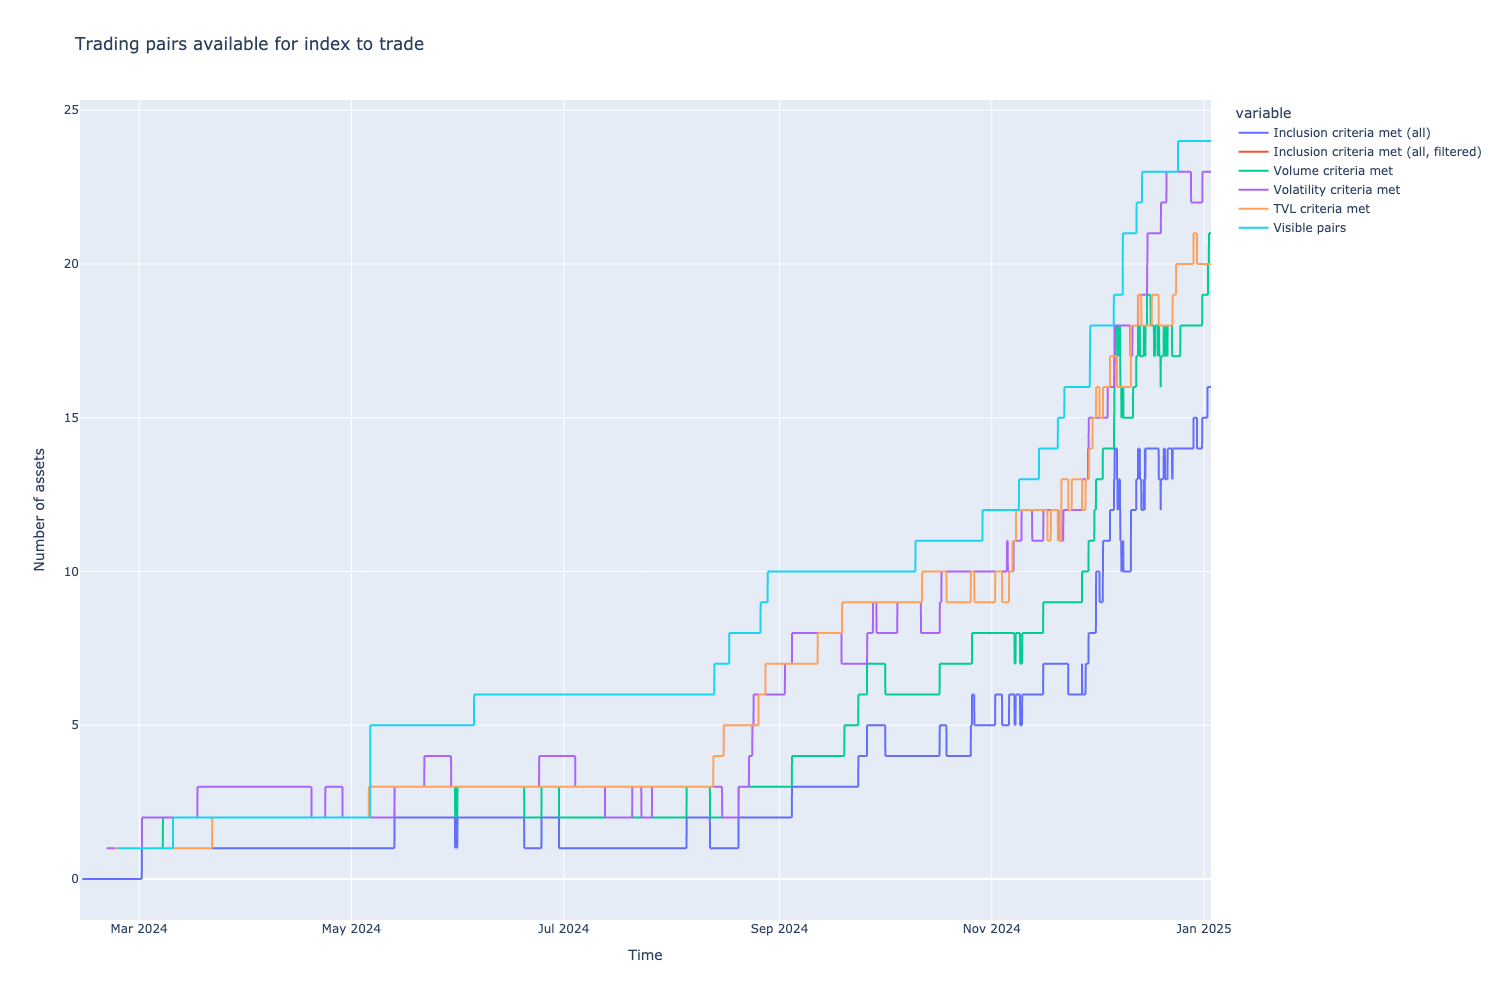

Inclusion criteria met (all)  \
2025-01-02 20:00:00                          16.0   
2025-01-02 21:00:00                          16.0   
2025-01-02 22:00:00                          16.0   
2025-01-02 23:00:00                          16.0   
2025-01-03 00:00:00                          16.0   

                     Inclusion criteria met (all, filtered)  \
2025-01-02 20:00:00                                     NaN   
2025-01-02 21:00:00                                     NaN   
2025-01-02 22:00:00                                     NaN   
2025-01-02 23:00:00                                     NaN   
2025-01-03 00:00:00                                     NaN   

                     Volume criteria met  Volatility criteria met  \
2025-01-02 20:00:00                 21.0                     23.0   
2025-01-02 21:00:00                 21.0                     23.0   
2025-01-02 22:00:00                 21.0                     23.0   
2025-01-02 23:00:00                 21.0                     23.0   
2025-01-03 00:00:00                 21.0                     23.0   

                     TVL criteria met  Visible pairs  
2025-01-02 20:00:00              20.0           24.0  
2025-01-02 21:00:00              20.0           24.0  
2025-01-02 22:00:00              20.0           24.0  
2025-01-02 23:00:00              20.0           24.0  
2025-01-03 00:00:00              20.0           24.0

In [6]:
import plotly.express as px

df = pd.DataFrame({
    "Inclusion criteria met (all)": indicator_data.get_indicator_series("all_criteria_included_pair_count"),
    "Inclusion criteria met (all, filtered)": indicator_data.get_indicator_series("all_criteria_included_pair_count_filtered"),
    "Volume criteria met": indicator_data.get_indicator_series("volume_included_pair_count"),
    "Volatility criteria met": indicator_data.get_indicator_series("volatility_included_pair_count"),
    "TVL criteria met": indicator_data.get_indicator_series("tvl_included_pair_count"),
    "Visible pairs": indicator_data.get_indicator_series("trading_pair_count"),
})

fig = px.line(df, title='Trading pairs available for index to trade')
fig.update_yaxes(title="Number of assets")
fig.update_xaxes(title="Time")
fig.show()

display(df.tail(5))

Find the first availability, or admission to index, of all trading pairs.

In [7]:
series = indicator_data.get_indicator_series("inclusion_criteria_jittered")

exploded = series.explode()
first_appearance_series = exploded.groupby(exploded.values).apply(lambda x: x.index[0])

df = pd.DataFrame({
    "Included at": first_appearance_series
})

df["Ticker"] = first_appearance_series.index.map(lambda pair_id: strategy_universe.get_pair_by_id(pair_id).get_ticker())
df["DEX"] = first_appearance_series.index.map(lambda pair_id: strategy_universe.get_pair_by_id(pair_id).exchange_name)
df = df.sort_values("Included at")

def _map_tvl(row):
    pair_id = row.name  # Indxe
    timestamp = row["Included at"]
    tvl, delay = strategy_universe.data_universe.liquidity.get_liquidity_with_tolerance(
        pair_id,
        timestamp,
        tolerance=pd.Timedelta(days=2),
    )
    return tvl

# Get the first entry and value of rolling cum volume of each pair
volume_series = indicator_data.get_indicator_data_pairs_combined("rolling_cumulative_volume")
first_volume_df = volume_series.reset_index().groupby("pair_id").first()

def _map_volume_timestamp(row):
    pair_id = row.name  # Index
    try:
        return first_volume_df.loc[pair_id]["timestamp"]
    except KeyError:
        return None
    
def _map_volume_value(row):
    pair_id = row.name  # Index
    try:
        return first_volume_df.loc[pair_id]["value"]
    except KeyError:
        return None

df["TVL at inclusion"] = df.apply(_map_tvl, axis=1)
df["Rolling volume first entry at"] = df.apply(_map_volume_timestamp, axis=1)
df["Rolling volume initial"] = df.apply(_map_volume_value, axis=1)

print(f"First appearances of {len(df)} trading pairs, when they meet all inclusion criteria:")

with pd.option_context("display.float_format", "{:,.2f}".format):
    display(df)


First appearances of 20 trading pairs, when they meet all inclusion criteria:


Included at        Ticker         DEX  TVL at inclusion  \
3746819 2024-03-01 19:00:00     FROK-WETH  uniswap-v2        398,050.42   
4646226 2024-05-13 09:00:00     SPEC-WETH  uniswap-v3      2,484,024.52   
4684678 2024-08-20 06:00:00      TIG-USDC  uniswap-v3      2,556,007.75   
4693966 2024-09-04 14:00:00     AUKI-WETH  uniswap-v3        216,437.96   
4691117 2024-09-23 16:00:00   imgnAI-WETH  uniswap-v3        228,371.68   
4486026 2024-09-26 04:00:00    AGENT-USDC  uniswap-v2        118,013.86   
4734514 2024-10-17 01:00:00     CARV-WETH  uniswap-v3         27,299.71   
4761685 2024-11-15 19:00:00  CLANKER-WETH  uniswap-v3        553,018.44   
4913705 2024-11-26 23:00:00    HENLO-WETH  uniswap-v3         37,910.78   
4917100 2024-11-28 20:00:00      REI-WETH  uniswap-v3      2,439,533.48   
4835302 2024-12-01 00:00:00    AIFUN-WETH  uniswap-v3        240,308.56   
4073069 2024-12-02 22:00:00     SKAI-USDT  uniswap-v2        123,500.50   
4933380 2024-12-06 04:00:00      FAI-WETH  uniswap-v3        772,841.07   
4686134 2024-12-06 08:00:00    AIKEK-WETH  uniswap-v3         46,125.92   
4748433 2024-12-11 00:00:00  VIRTUAL-WETH  uniswap-v3         91,778.61   
4951400 2024-12-13 01:00:00      ORA-WETH  uniswap-v3      3,981,104.50   
4988990 2024-12-19 14:00:00     PACA-WETH  uniswap-v3         42,469.35   
4933470 2024-12-29 00:00:00   NFTXBT-WETH  uniswap-v3         26,236.16   
5057038 2024-12-31 12:00:00     ALCH-WETH  uniswap-v3        337,234.93   
4962849 2025-01-01 00:00:00      BRO-WETH  uniswap-v3         36,389.13   

        Rolling volume first entry at  Rolling volume initial  
3746819           2024-02-23 20:00:00              372,648.70  
4646226           2024-05-06 10:00:00           44,352,976.50  
4684678           2024-08-13 07:00:00            4,617,347.48  
4693966           2024-08-28 15:00:00              738,236.78  
4691117           2024-08-26 14:00:00               43,943.00  
4486026           2024-09-19 05:00:00            1,344,241.87  
4734514           2024-10-10 02:00:00            2,140,811.00  
4761685           2024-11-08 20:00:00           10,016,785.78  
4913705           2024-11-20 00:00:00            1,314,730.60  
4917100           2024-11-21 21:00:00           20,372,987.22  
4835302           2024-11-14 14:00:00                3,374.00  
4073069           2024-08-16 06:00:00               20,724.47  
4933380           2024-11-29 05:00:00           13,878,219.76  
4686134           2024-08-17 14:00:00               47,988.54  
4748433           2024-10-29 09:00:00               29,320.68  
4951400           2024-12-06 02:00:00           11,032,539.25  
4988990           2024-12-12 15:00:00              464,542.66  
4933470           2024-11-29 07:00:00            6,574,560.02  
5057038           2024-12-24 13:00:00           12,008,123.74  
4962849           2024-12-08 16:00:00              112,930.71

In [8]:
# ts = pd.Timestamp("2024-02-14 02:00:00")
# series = indicator_data.get_indicator_data_pairs_combined("tvl")
# display(series.loc[(4572399, ts)])

# #display(series)
# mask = series >= Parameters.min_tvl
# # Turn to a series of lists
# mask_true_values_only = mask[mask == True]
# display(mask_true_values_only)
# series = mask_true_values_only.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())


# #display(mask.reset_index().groupby("timestamp"))
# #display(mask[(4572399, ts)])
# display(series[ts])
# display(series)


# Backtest time range

- Choose the backtesting time range
- Start when we have enough assets (`Parameters.min_asset_universe`) in our asset universe to form the first basket

In [9]:
series = indicator_data.get_indicator_series("all_criteria_included_pair_count")

exceeds_threshold = series > Parameters.min_asset_universe
# Get the first date where the condition is True
backtest_start = exceeds_threshold[exceeds_threshold].first_valid_index()
backtest_end = series.index[-1]

print(f"Time range is {backtest_start} - {backtest_end}")

Time range is 2024-09-23 16:00:00 - 2025-01-03 00:00:00


# Strategy algorithm and backtest

- Run the backtest

In [10]:
from tradeexecutor.backtest.backtest_runner import run_backtest_inline
from tradeexecutor.strategy.alpha_model import AlphaModel
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pandas_trader.strategy_input import StrategyInput, IndicatorDataNotFoundWithinDataTolerance
from tradeexecutor.state.visualisation import PlotKind
from tradeexecutor.backtest.backtest_runner import run_backtest_inline
from tradeexecutor.strategy.tvl_size_risk import USDTVLSizeRiskModel
from tradeexecutor.strategy.weighting import weight_by_1_slash_n, weight_passthrouh, weight_equal
from tradeexecutor.utils.dedent import dedent_any


def decide_trades(
    input: StrategyInput
) -> list[TradeExecution]:
    """For each strategy tick, generate the list of trades."""
    parameters = input.parameters
    position_manager = input.get_position_manager()
    state = input.state
    timestamp = input.timestamp
    indicators = input.indicators
    strategy_universe = input.strategy_universe

    # Build signals for each pair 
    alpha_model = AlphaModel(
        timestamp,
        close_position_weight_epsilon=parameters.min_portfolio_weight,  # 10 BPS is our min portfolio weight
    )

    # Prepare diagnostics variables
    max_vol = (0, None)  
    signal_count = 0  
    vol_pair = strategy_universe.get_pair_by_human_description(VOL_PAIR)
    volume_included_pair_count = indicators.get_indicator_value(
        "volume_included_pair_count",
    )
    volatility_included_pair_count = indicators.get_indicator_value(
        "volatility_included_pair_count",
    ) 
    tvl_included_pair_count = indicators.get_indicator_value(
        "tvl_included_pair_count",
    )
    
    # Get pairs included in this rebalance cycle.
    # This includes pair that have been pre-cleared in inclusion_criteria()
    # with volume, volatility and TVL filters 
    included_pairs = indicators.get_indicator_value(
        "inclusion_criteria_jittered",
        na_conversion=False,
    )
    if included_pairs is None:
        included_pairs = []

    ref_vol = indicators.get_indicator_value(
        "volatility",
        pair=vol_pair,
    )


    # Set signal for each pair
    for pair_id in included_pairs:
        pair = strategy_universe.get_pair_by_id(pair_id)

        volatility = indicators.get_indicator_value(
            "volatility_ewm",
            pair=pair,
        )

        weight = volatility
        if volatility is None or volatility == 0:
            continue

        alpha_model.set_signal(
            pair,
            weight,
        )

        # Diagnostics reporting
        signal_count += 1
        if volatility > max_vol[0]:
            max_vol = (volatility, pair)

    # Calculate how much dollar value we want each individual position to be on this strategy cycle,
    # based on our total available equity
    portfolio = position_manager.get_current_portfolio()
    portfolio_target_value = portfolio.get_total_equity() * parameters.allocation - position_manager.get_pending_redemptions()

    # Select max_assets_in_portfolio assets in which we are going to invest
    # Calculate a weight for ecah asset in the portfolio using 1/N method based on the raw signal
    alpha_model.select_top_signals(count=parameters.max_assets_in_portfolio)
    alpha_model.assign_weights(method=weight_passthrouh)
    # alpha_model.assign_weights(method=weight_by_1_slash_n)

    #
    # Normalise weights and cap the positions
    # 
    size_risk_model = USDTVLSizeRiskModel(
        pricing_model=input.pricing_model,
        per_position_cap=parameters.per_position_cap_of_pool,  # This is how much % by all pool TVL we can allocate for a position
        missing_tvl_placeholder_usd=parameters.assummed_liquidity_when_data_missings,  # Placeholder for missing TVL data until we get the data off the chain
    )

    alpha_model.normalise_weights(
        investable_equity=portfolio_target_value,
        size_risk_model=size_risk_model,
        max_weight=parameters.max_concentration,
    )

    # Load in old weight for each trading pair signal,
    # so we can calculate the adjustment trade size
    alpha_model.update_old_weights(
        state.portfolio,
        ignore_credit=True,
    )
    alpha_model.calculate_target_positions(position_manager)

    # Shift portfolio from current positions to target positions
    # determined by the alpha signals (momentum)
    
    # rebalance_threshold_usd = portfolio_target_value * parameters.min_rebalance_trade_threshold_pct
    rebalance_threshold_usd = parameters.individual_rebalance_min_threshold_usd
    
    assert rebalance_threshold_usd > 0.1, "Safety check tripped - something like wrong with strat code"
    trades = alpha_model.generate_rebalance_trades_and_triggers(
        position_manager,
        min_trade_threshold=rebalance_threshold_usd,  # Don't bother with trades under XXXX USD
        invidiual_rebalance_min_threshold=parameters.individual_rebalance_min_threshold_usd,
        execution_context=input.execution_context,
    )

    # Add verbal report about decision made/not made,
    # so it is much easier to diagnose live trade execution.
    # This will be readable in Discord/Telegram logging.
    if input.is_visualisation_enabled():
        try:
            top_signal = next(iter(alpha_model.get_signals_sorted_by_weight()))
            if top_signal.normalised_weight == 0:
                top_signal = None
        except StopIteration:
            top_signal = None

        max_vol_pair = max_vol[1]
        if max_vol_pair:
            max_vol_signal = alpha_model.get_signal_by_pair(max_vol_pair)
        else:
            max_vol_signal = None

        vol_pair_vol = indicators.get_indicator_value("volatility_ewm", pair=vol_pair)

        rebalance_volume = sum(t.get_value() for t in trades)
        
        report = dedent_any(f"""
        Cycle: #{input.cycle}
        Rebalanced: {'👍' if alpha_model.is_rebalance_triggered() else '👎'}
        Open/about to open positions: {len(state.portfolio.open_positions)} 
        Max position value change: {alpha_model.max_position_adjust_usd:,.2f} USD
        Rebalance threshold: {alpha_model.position_adjust_threshold_usd:,.2f} USD
        Trades decided: {len(trades)}
        Pairs total: {strategy_universe.data_universe.pairs.get_count()}
        Pairs meeting inclusion criteria: {len(included_pairs)}
        Pairs meeting volume inclusion criteria: {volume_included_pair_count}
        Pairs meeting volatility inclusion criteria: {volatility_included_pair_count}        
        Pairs meeting TVL inclusion criteria: {tvl_included_pair_count}        
        Signals created: {signal_count}
        Total equity: {portfolio.get_total_equity():,.2f} USD
        Cash: {position_manager.get_current_cash():,.2f} USD
        Investable equity: {alpha_model.investable_equity:,.2f} USD
        Accepted investable equity: {alpha_model.accepted_investable_equity:,.2f} USD
        Allocated to signals: {alpha_model.get_allocated_value():,.2f} USD
        Discarted allocation because of lack of lit liquidity: {alpha_model.size_risk_discarded_value:,.2f} USD
        Rebalance volume: {rebalance_volume:,.2f} USD
        {vol_pair.base.token_symbol} volatility: {vol_pair_vol}        
        Most volatility pair: {max_vol_pair.get_ticker() if max_vol_pair else '-'}
        Most volatility pair vol: {max_vol[0]}
        Most volatility pair signal value: {max_vol_signal.signal if max_vol_signal else '-'}
        Most volatility pair signal weight: {max_vol_signal.raw_weight if max_vol_signal else '-'}        
        """)

        # Most volatility pair signal weight (normalised): {max_vol_signal.normalised_weight * 100 if max_vol_signal else '-'} % (got {max_vol_signal.position_size_risk.get_relative_capped_amount() * 100 if max_vol_signal else '-'} % of asked size)
        if top_signal:
            top_signal_vol = indicators.get_indicator_value("volatility_ewm", pair=top_signal.pair)
            assert top_signal.position_size_risk
            report += dedent_any(f"""
            Top signal pair: {top_signal.pair.get_ticker()}
            Top signal volatility: {top_signal_vol}
            Top signal value: {top_signal.signal}
            Top signal weight: {top_signal.raw_weight}
            Top signal weight (normalised): {top_signal.normalised_weight * 100:.2f} % (got {top_signal.position_size_risk.get_relative_capped_amount() * 100:.2f} % of asked size)
            """)            

        for flag, count in alpha_model.get_flag_diagnostics_data().items():
            report += f"Signals with flag {flag.name}: {count}\n"

        state.visualisation.add_message(
            timestamp,
            report, 
        )

        state.visualisation.set_discardable_data("alpha_model", alpha_model)

    return trades  # Return the list of trades we made in this cycle


result = run_backtest_inline(
    name=parameters.id,
    engine_version="0.5",
    decide_trades=decide_trades,
    create_indicators=indicators.create_indicators,
    client=client,
    universe=strategy_universe,
    parameters=parameters,
    # log_level=logging.INFO,
    max_workers=1,
    start_at=backtest_start.to_pydatetime(),
    end_at=backtest_end.to_pydatetime(),
)

state = result.state

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

Reading cached indicators rsi, roc, obv, trailing_sharpe, trailing_sharpe_ewm, volatility, volatility_ewm, mea…

Using indicator cache /Users/moo/.cache/indicators/base_1h_26_2024-02-13-2025-01-03_ff


  0%|          | 0/8755200 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 1666 trades


# Performance metrics

- Display portfolio performance metrics
- Compare against buy and hold matic using the same initial capital

**Note**: Some of these metrics might be incorrect due to slow start of the strategy

In [11]:
from tradeexecutor.analysis.multi_asset_benchmark import compare_strategy_backtest_to_multiple_assets

compare_strategy_backtest_to_multiple_assets(
    state,
    strategy_universe,
    display=True,
    interesting_assets=["WETH", "CLANKER", "VIRTUAL"],
)

Strategy                  ETH  \
Start Period                        2024-09-23           2024-09-23   
End Period                          2025-01-02           2025-01-02   
Risk-Free Rate                            0.0%                 0.0%   
Time in Market                          100.0%                99.0%   
Cumulative Return                      631.37%               28.51%   
CAGR﹪                                14224.14%               86.99%   
Sharpe                                    6.07                 1.79   
Prob. Sharpe Ratio                      100.0%               83.28%   
Smart Sharpe                              6.04                 1.79   
Sortino                                  15.08                 2.96   
Smart Sortino                            15.02                 2.95   
Sortino/√2                               10.66                 2.09   
Smart Sortino/√2                         10.62                 2.09   
Omega                                     2.56                 2.56   
Max Drawdown                           -21.08%              -19.26%   
Longest DD Days                             42                   26   
Volatility (ann.)                      131.58%               59.95%   
Calmar                                  674.63                 4.52   
Skew                                      1.63                 0.48   
Kurtosis                                  5.74                  0.7   
Expected Daily                           1.97%                0.25%   
Expected Monthly                        48.88%                5.15%   
Expected Yearly                        170.44%               13.36%   
Kelly Criterion                         35.23%                 0.6%   
Risk of Ruin                              0.0%                 0.0%   
Daily Value-at-Risk                     -9.14%               -4.87%   
Expected Shortfall (cVaR)               -9.14%               -4.87%   
Max Consecutive Wins                         8                    7   
Max Consecutive Losses                       5                    6   
Gain/Pain Ratio                           1.56                 0.28   
Gain/Pain (1M)                            27.6                 5.09   
Payoff Ratio                              1.86                  1.1   
Profit Factor                             2.56                 1.28   
Common Sense Ratio                        5.79                 1.71   
CPC Index                                 2.76                 0.67   
Tail Ratio                                2.26                 1.34   
Outlier Win Ratio                         4.71                  7.0   
Outlier Loss Ratio                         2.4                 3.41   
MTD                                      4.84%                1.19%   
3M                                      600.3%               28.86%   
6M                                     631.37%               28.51%   
YTD                                      4.84%                1.19%   
1Y                                     631.37%               28.51%   
3Y (ann.)                            14224.14%               86.99%   
5Y (ann.)                            14224.14%               86.99%   
10Y (ann.)                           14224.14%               86.99%   
All-time (ann.)                      14224.14%               86.99%   
Best Day                                34.31%               10.05%   
Worst Day                              -14.02%               -6.39%   
Best Month                              172.1%               34.77%   
Worst Month                            -10.13%               -7.14%   
Best Year                              597.64%                27.0%   
Worst Year                               4.84%                1.19%   
Avg. Drawdown                           -7.39%               -7.25%   
Avg. Drawdown Days                           6                    9   
Recovery Factor                          10.58                

# Equity curve

- Equity curve shows how your strategy accrues value over time

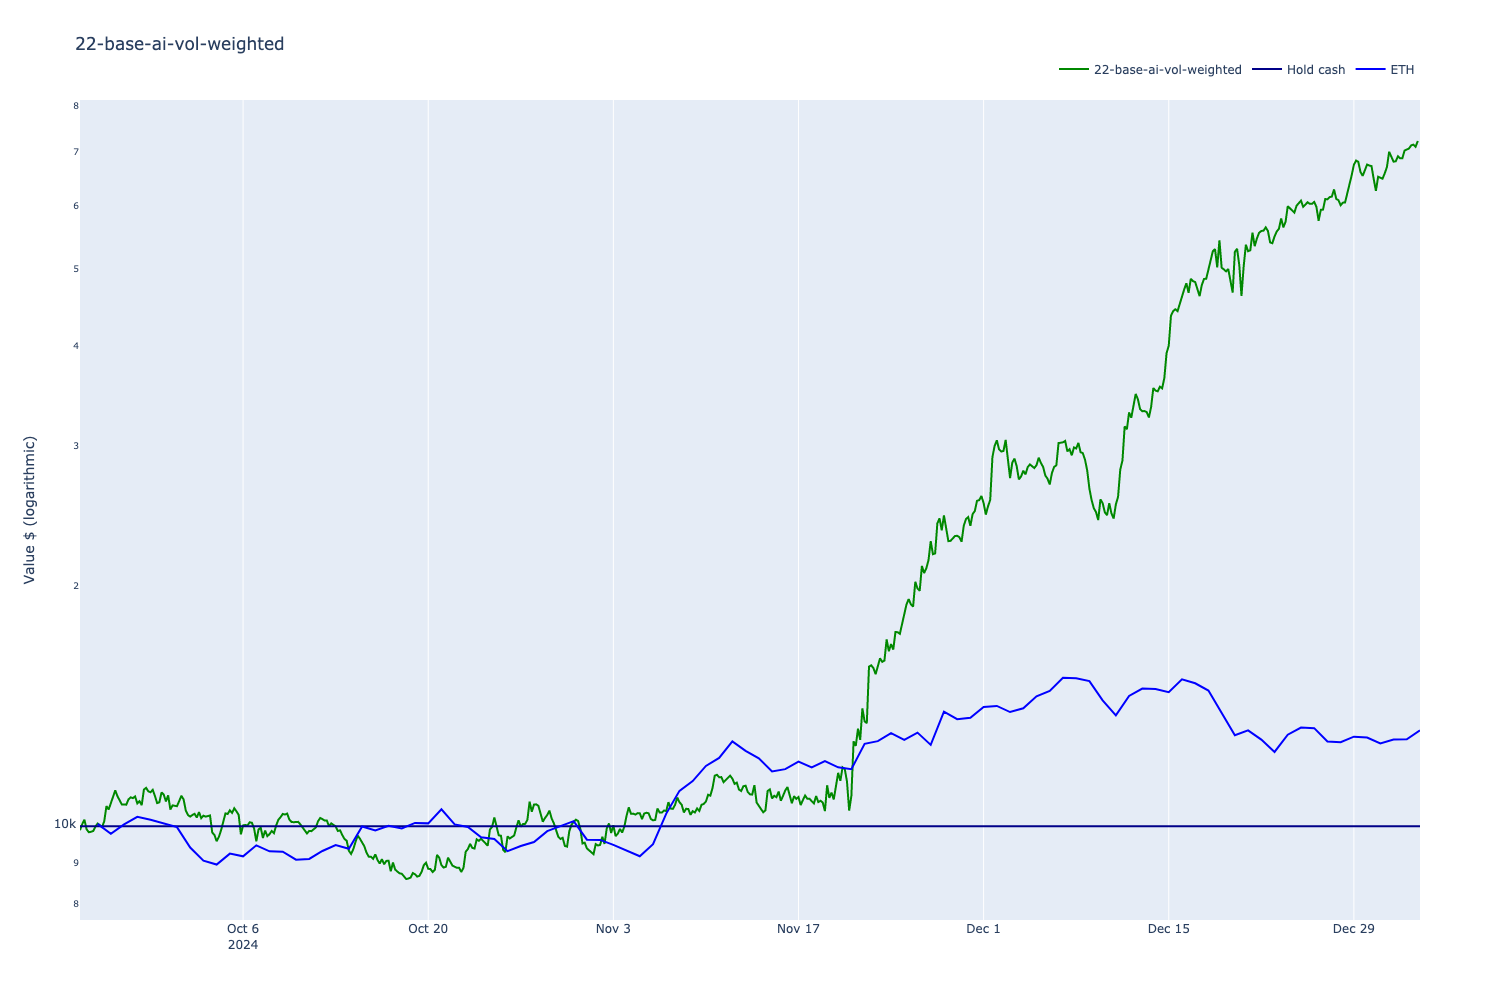

In [12]:
import pandas as pd
from tradeexecutor.analysis.multi_asset_benchmark import get_benchmark_data
from tradeexecutor.visual.benchmark import visualise_equity_curve_benchmark

benchmark_indexes = get_benchmark_data(
    strategy_universe,
    cumulative_with_initial_cash=state.portfolio.get_initial_cash(),
    max_count=4,
    start_at=state.get_trading_time_range()[0],
    interesting_assets=["WETH", "CLANKER", "VIRTUAL"],
)

fig = visualise_equity_curve_benchmark(
    state=state,    
    benchmark_indexes=benchmark_indexes,
    height=800,
    log_y=True,
)

fig.show()

## Equity curve with drawdown

- Linear curve

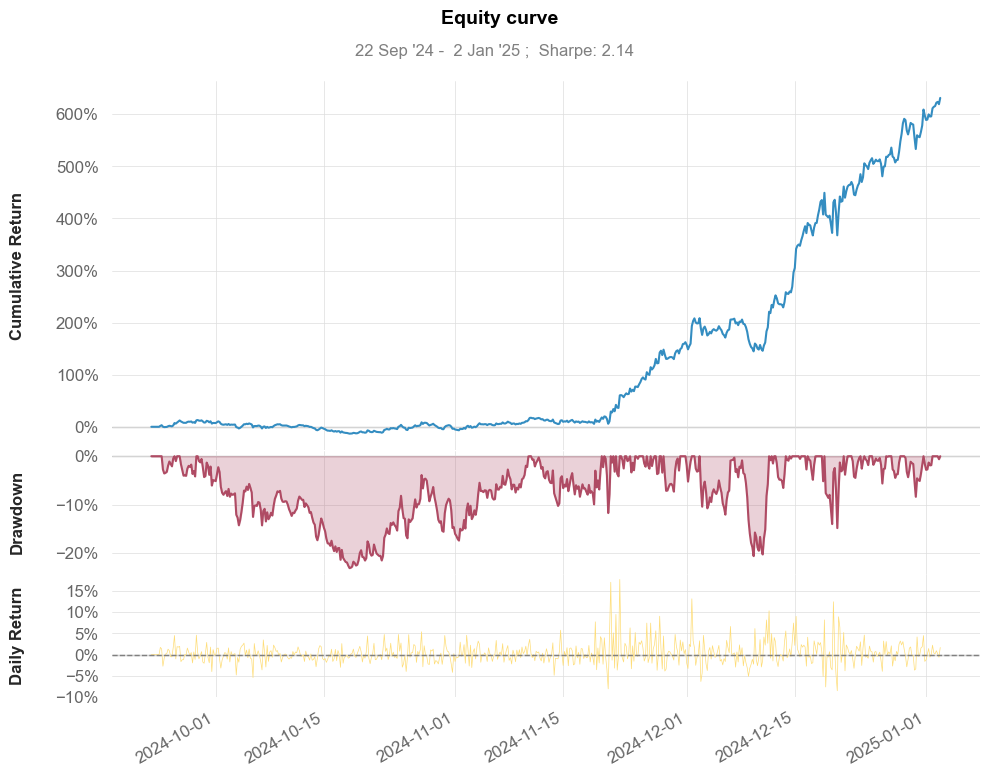

In [13]:
from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.visual.equity_curve import visualise_equity_curve

curve = calculate_equity_curve(state)
returns = calculate_returns(curve)
fig = visualise_equity_curve(returns)
display(fig)

# Asset weights

- What assets were allocated over time
- Do both proportional % and USD weights

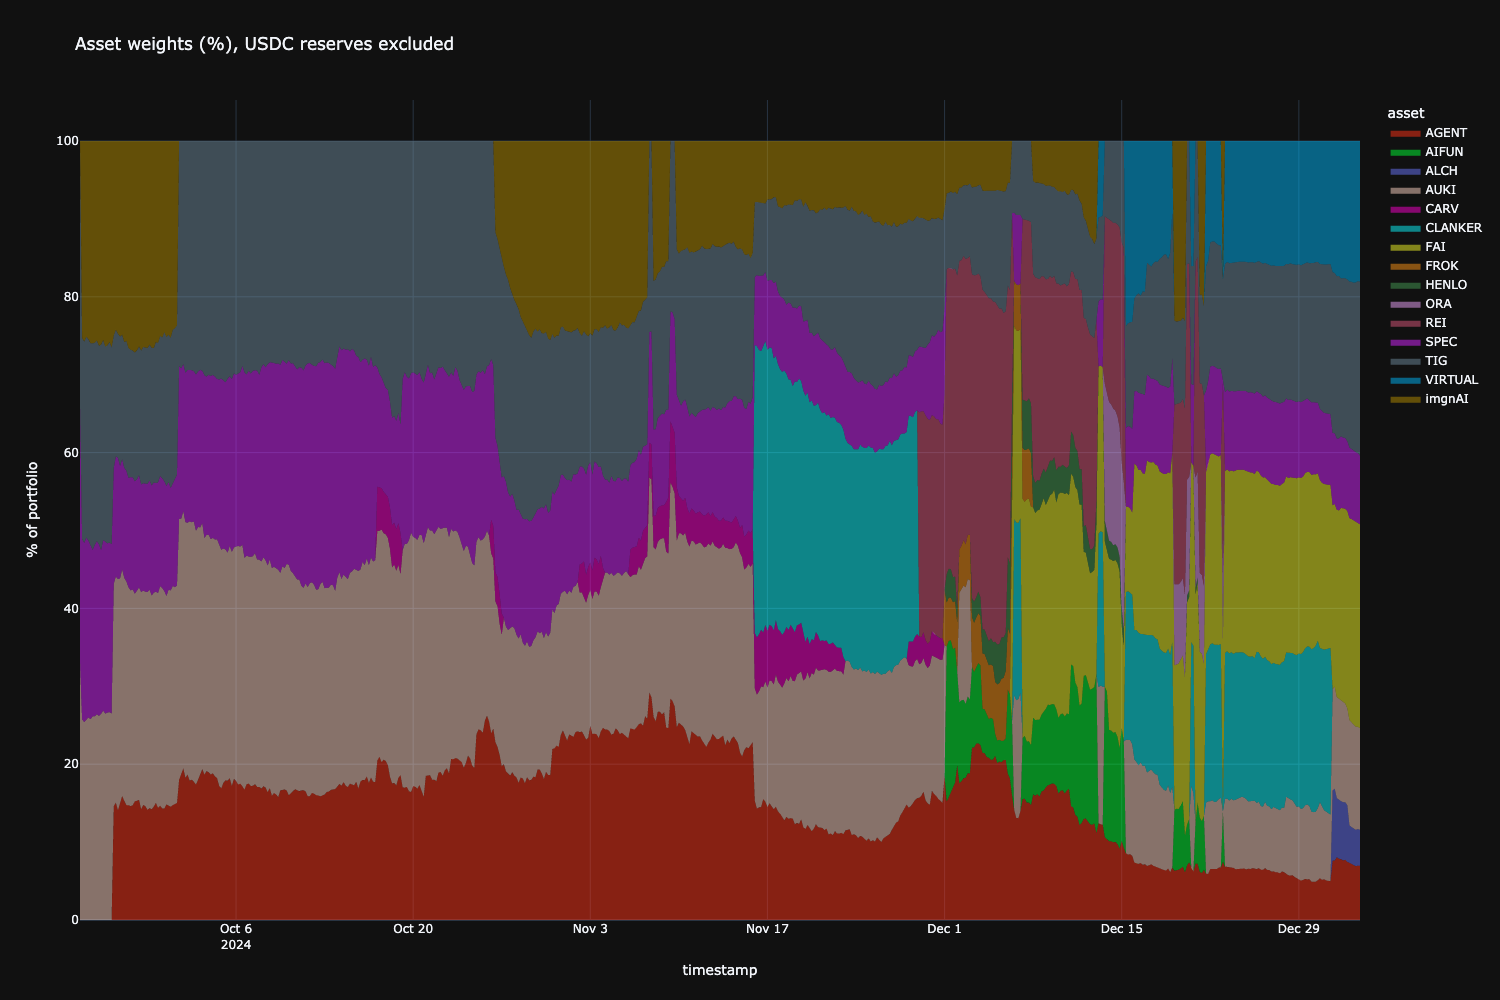

In [14]:
from tradeexecutor.analysis.weights import calculate_asset_weights, visualise_weights

weights_series = calculate_asset_weights(state)

fig = visualise_weights(
    weights_series,
    normalised=True,
    include_reserves=False,
)
fig.show()

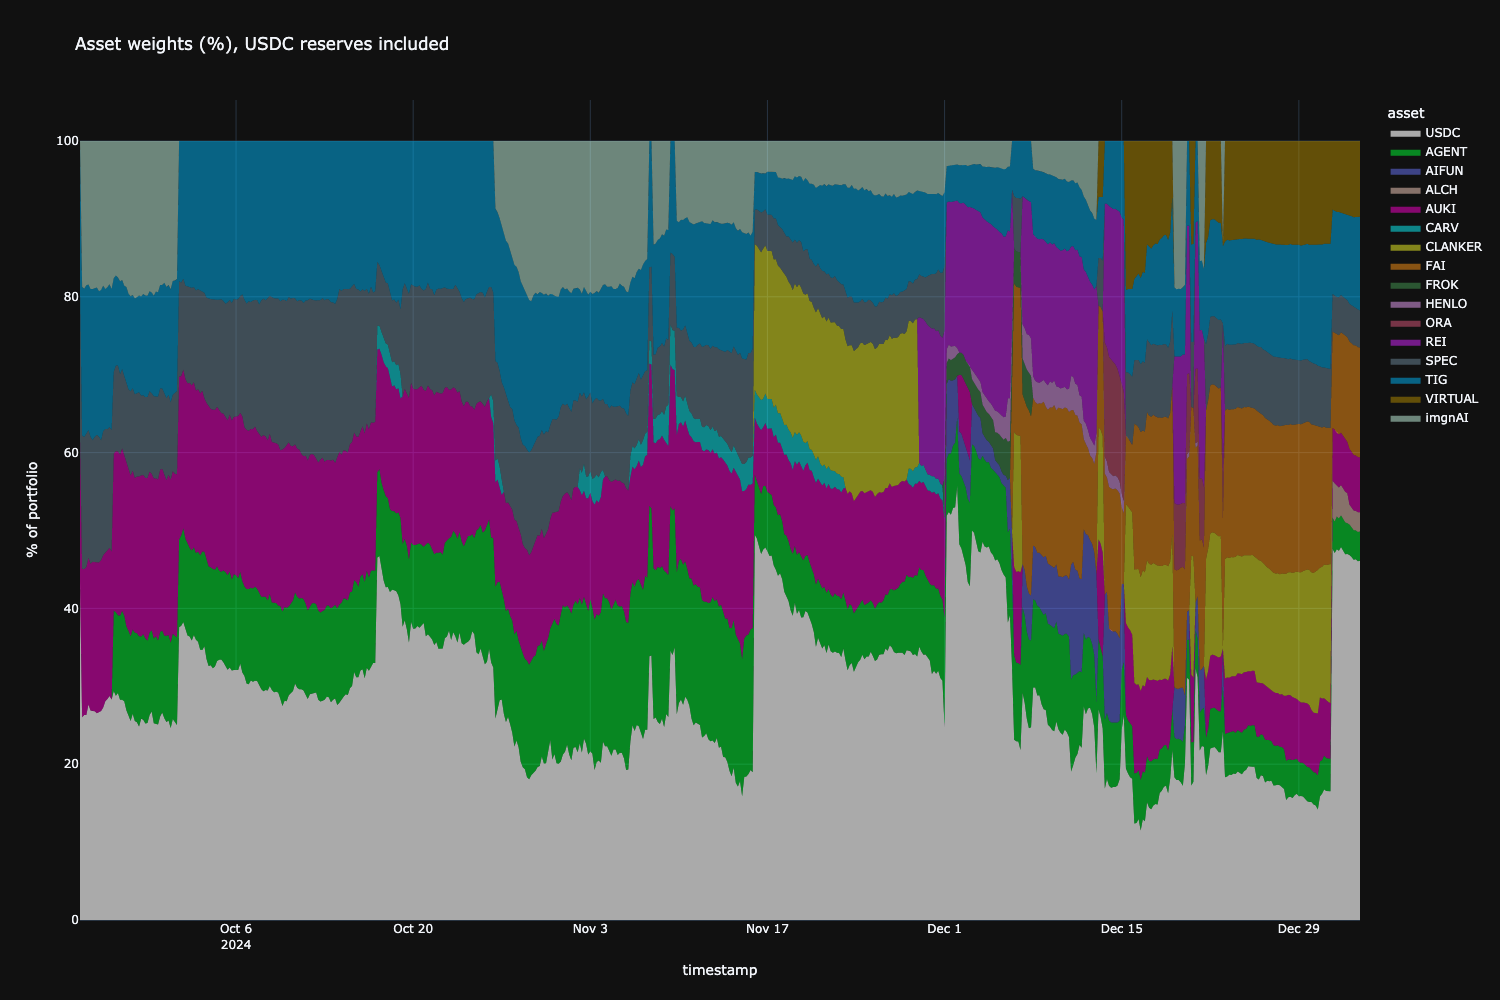

In [15]:

fig = visualise_weights(
    weights_series,
    normalised=True,
    include_reserves=True,
)
fig.show()

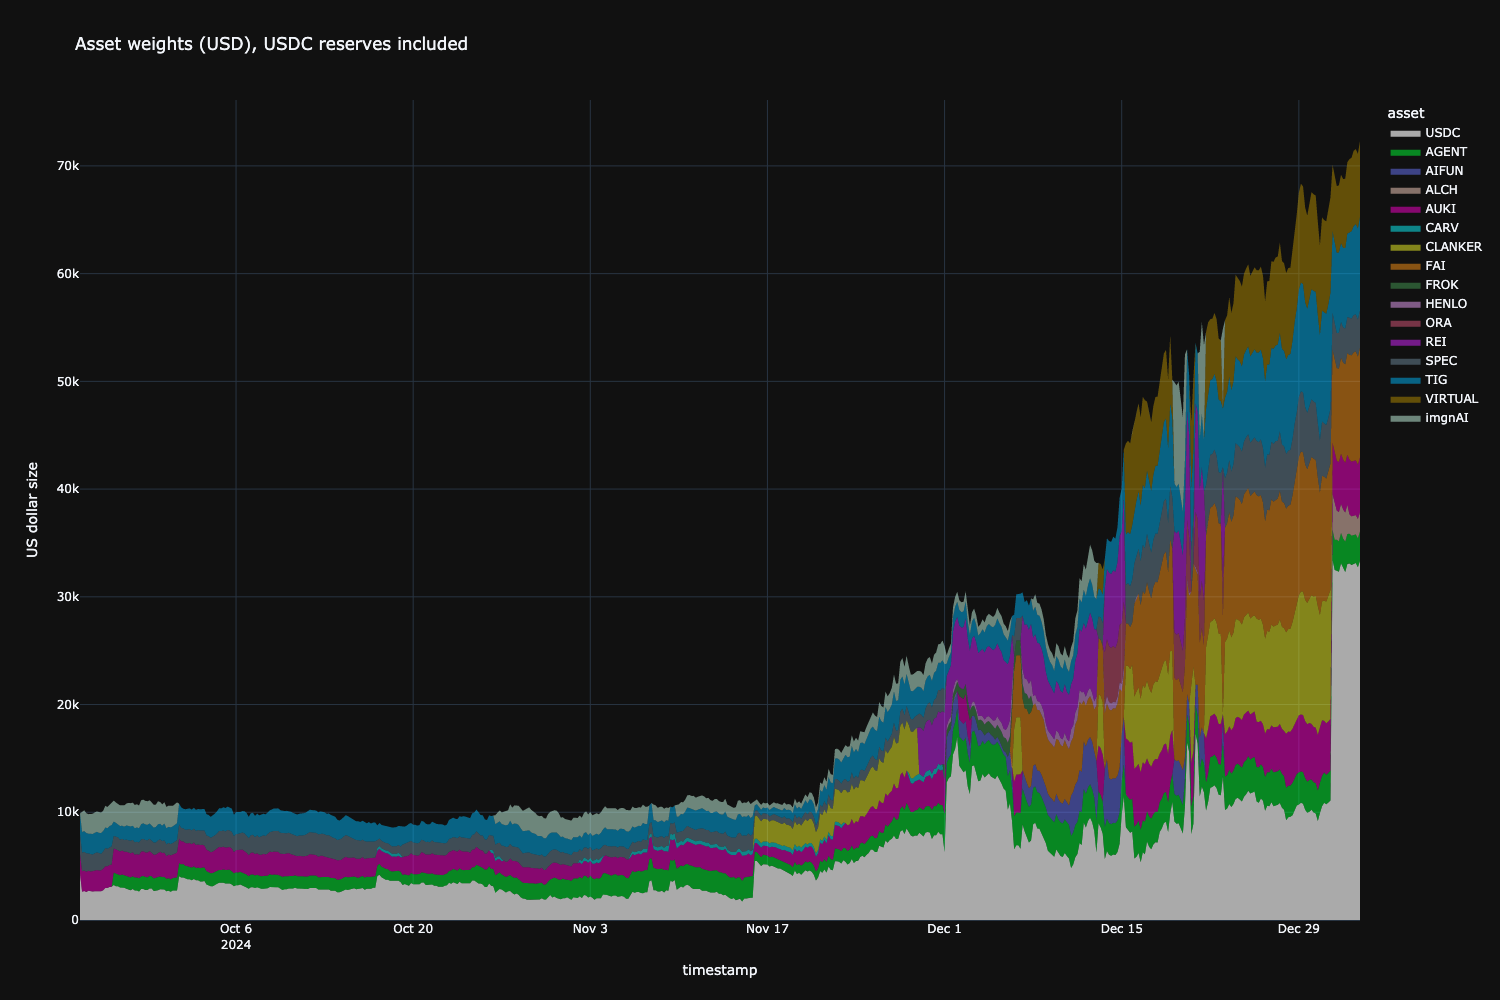

In [16]:
df = weights_series.unstack(level=1)

fig = visualise_weights(
    weights_series,
    normalised=False,
)
fig.show()

## Weight allocation statistics



In [17]:
from tradeexecutor.analysis.weights import calculate_weights_statistics

stats = calculate_weights_statistics(weights_series)
display(stats)


At   Pair      Value Unit
Name                                                                      
Max position (excluding USDC)   2024-12-29 04:00:00    FAI  12,991.45  USD
Min position (excluding USDC)   2024-11-04 00:00:00   CARV     125.64  USD
Mean position (excluding USDC)                               2,874.97  USD
Max position (excluding USDC)   2024-12-04 12:00:00    REI      44.03    %
Min position (excluding USDC)   2024-12-21 00:00:00  HENLO       0.69    %
Mean position (excluding USDC)                                  17.36    %
Max position (including USDC)   2024-12-02 00:00:00   USDC      55.76    %
Min position (including USDC)   2024-12-21 00:00:00  HENLO       0.48    %
Mean position (including USDC)                                  14.79    %

# Positions at the end

Some example positions at the end


In [18]:

for p in list(state.portfolio.open_positions.values())[0:10]:
    print(f"Position {p.pair.base.token_symbol}, value {p.get_value()} USD")

Position TIG, value 8701.593888617757 USD
Position AGENT, value 2715.6531623524743 USD
Position FAI, value 10197.936953396342 USD
Position AUKI, value 5084.431108119374 USD
Position VIRTUAL, value 7032.894444457038 USD
Position SPEC, value 3434.8371457242497 USD
Position ALCH, value 1792.0781197607214 USD


Examples of strategy thinking output 

- At the end of strategy
- Reverse order - last timestamp first

In [19]:
messages = state.visualisation.get_messages_tail(2)

table = pd.Series(
    data=list(messages.values()),
    index=list(messages.keys()),
)

df = table.to_frame()

display(df.style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap',
}))


# Alpha model diagnostics data

- Dump out alpha model contents from the last cycle

In [20]:
from tradeexecutor.strategy.alpha_model import format_signals

alpha_model = state.visualisation.discardable_data["alpha_model"]

print(f"All signals ({len(df)})")
df = format_signals(alpha_model, signal_type="all")
display(df)

All signals (2)


Signal    Asked size  Accepted size  Value adjust USD  \
Pair                                                                    
SPEC-WETH     0.008524    3432.82552    3432.825520       -201.162544   
CARV-WETH     0.009837             -            NaN          0.000000   
ORA-WETH      0.012947             -            NaN          0.000000   
VIRTUAL-WETH  0.017463   7033.183661    7033.183661        289.360928   
imgnAI-WETH   0.017861             -            NaN          0.000000   
AGENT-USDC    0.019544   7445.824799    2713.133866       -839.765491   
AUKI-WETH     0.019605   7271.711828    5082.301181       -212.992665   
TIG-USDC      0.023470   8705.288616    8705.288616        186.583753   
PACA-WETH     0.027114             -            NaN          0.000000   
FAI-WETH      0.027489  10195.764693   10195.764693       -217.226011   
CLANKER-WETH  0.029086             -            NaN          0.000000   
AIFUN-WETH    0.032656             -            NaN          0.000000   
HENLO-WETH    0.046825             -            NaN          0.000000   
REI-WETH      0.050009             -            NaN          0.000000   
BRO-WETH      0.080875             -            NaN          0.000000   
ALCH-WETH     0.101342  13741.425396    1799.645885        382.172149   

              Weights (raw)  Weights (norm/cap)  Old weight      Flipping  \
Pair                                                                        
SPEC-WETH          0.008524            0.088107    0.091825       no flip   
CARV-WETH          0.000000            0.000000    0.000000  none -> spot   
ORA-WETH           0.000000            0.000000    0.000000  none -> spot   
VIRTUAL-WETH       0.017463            0.180513    0.170405       no flip   
imgnAI-WETH        0.000000            0.000000    0.000000  none -> spot   
AGENT-USDC         0.019544            0.069635    0.089776       no flip   
AUKI-WETH          0.019605            0.130442    0.133803       no flip   
TIG-USDC           0.023470            0.223429    0.215254       no flip   
PACA-WETH          0.000000            0.000000    0.000000  none -> spot   
FAI-WETH           0.027489            0.261684    0.263119       no flip   
CLANKER-WETH       0.000000            0.000000    0.000000  none -> spot   
AIFUN-WETH         0.000000            0.000000    0.000000  none -> spot   
HENLO-WETH         0.000000            0.000000    0.000000  none -> spot   
REI-WETH           0.000000            0.000000    0.000000  none -> spot   
BRO-WETH           0.000000            0.000000    0.000000  none -> spot   
ALCH-WETH          0.101342            0.046190    0.035817       no flip   

                  TVL                                         Flags  
Pair                                                                 
SPEC-WETH     4552485                                                
CARV-WETH           0                                                
ORA-WETH            0                                                
VIRTUAL-WETH  2754177                                                
imgnAI-WETH         0                                                
AGENT-USDC     271313                           capped_by_pool_size  
AUKI-WETH      508230                           capped_by_pool_size  
TIG-USDC      1458724                                                
PACA-WETH           0                                                
FAI-WETH      6015178                                                
CLANKER-WETH        0                                                
AIFUN-WETH          0                                                
HENLO-WETH          0                                                
REI-WETH            0                                                
BRO-WETH            0                                                
ALCH-WETH      179965  capped_by_concentration, capped_by_pool_size

# Trading pair breakdown

- Trade success for each trading pair



In [21]:
from tradeexecutor.analysis.multipair import analyse_multipair
from tradeexecutor.analysis.multipair import format_multipair_summary

multipair_summary = analyse_multipair(state)
format_multipair_summary(multipair_summary, sort_column="Total return %")

# Trading metrics

- Trading cost, etc.

In [22]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)
summary = analysis.calculate_summary_statistics()
display(summary.to_dataframe())

# Indicator values



In [23]:
# Plot example indicators

import plotly.express as px

selected_assets = ["WETH", "cbBTC", "KEYCAT"]

checked_indicators = [
    # "volatility", 
    # "volatility_ewm", 
    # "trailing_sharpe_ewm", 
    "rsi",
    "roc",
    "obv"
]

for indicator_name in checked_indicators:

    data = {}
    for symbol in selected_assets:
        pair = token_map[symbol]
        data[symbol] = series = indicator_data.get_indicator_series(indicator_name, pair=pair)

        if series is None or len(series) == 0:
            print(f"Asset {symbol} has no data for {indicator_name}")

    df = pd.DataFrame(data)
    fig = px.line(df, title=f"{indicator_name.capitalize()}")
    fig.update_layout(showlegend=True)
    fig.update_yaxes(title=f"{indicator_name.capitalize()} value")
    fig.update_xaxes(title="Time")
    fig.show()

KeyError: 'KEYCAT'

# Single pair analysis



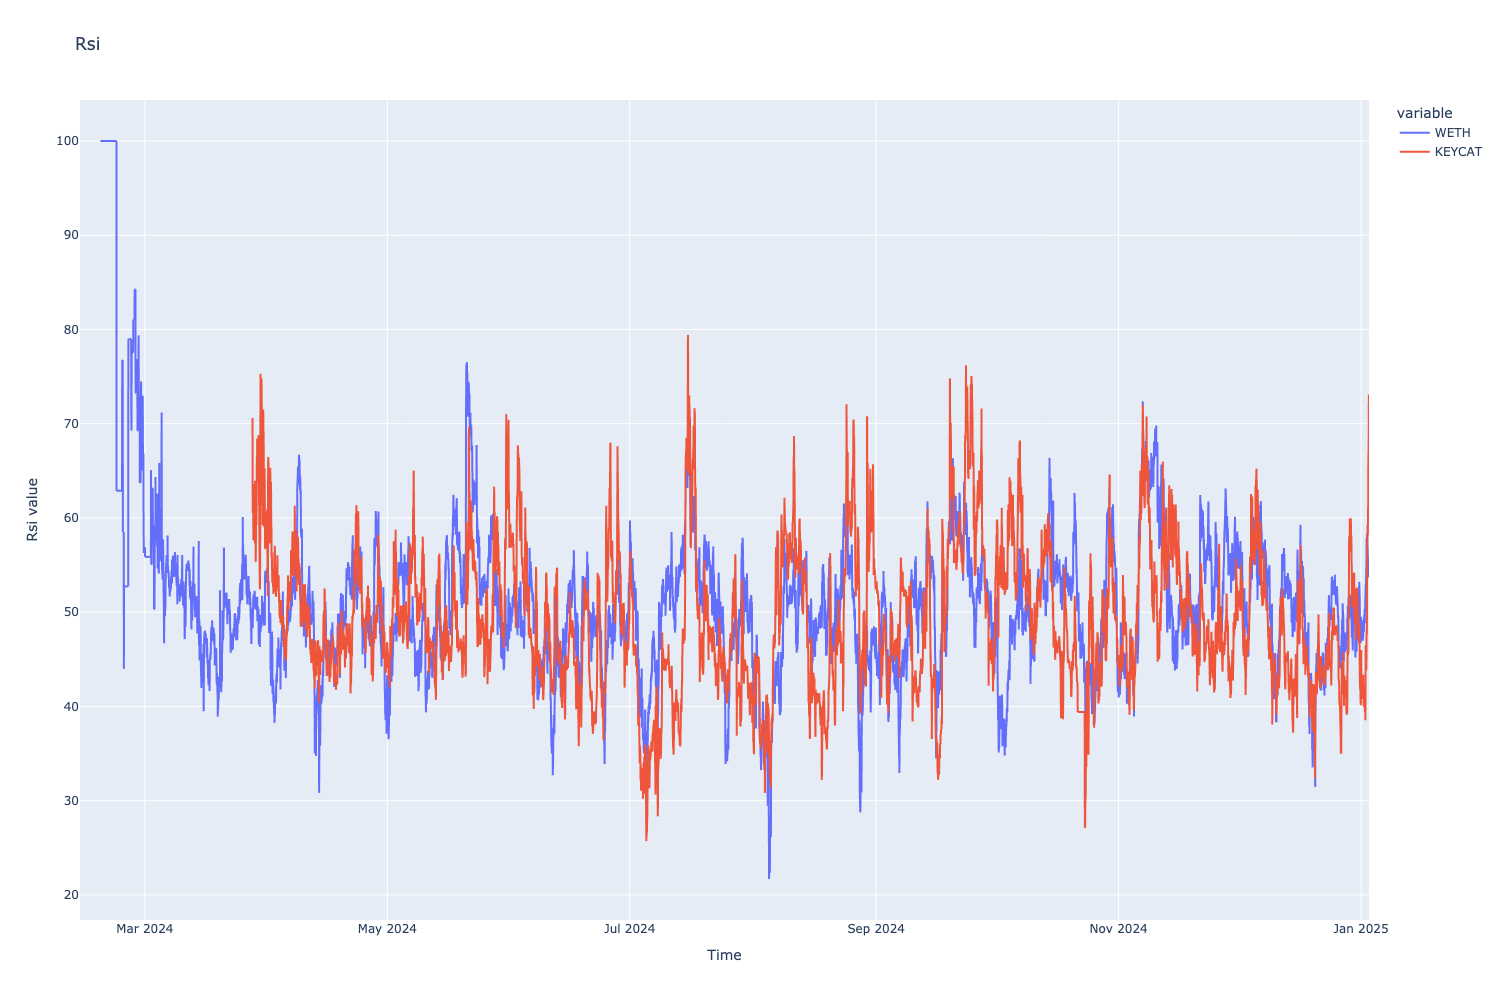

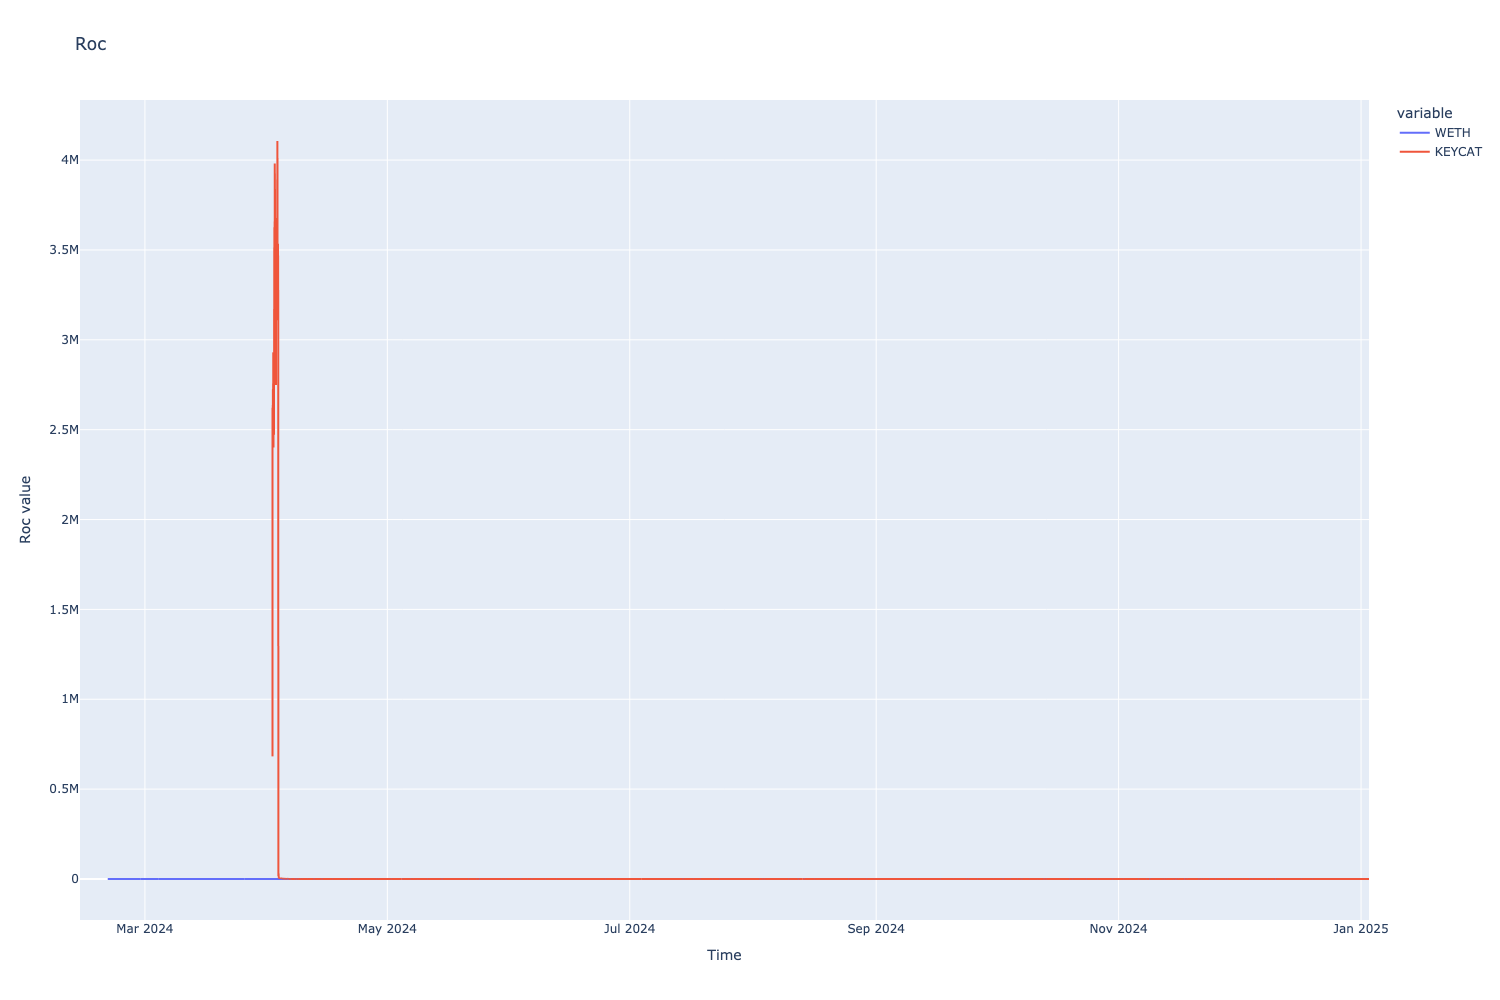

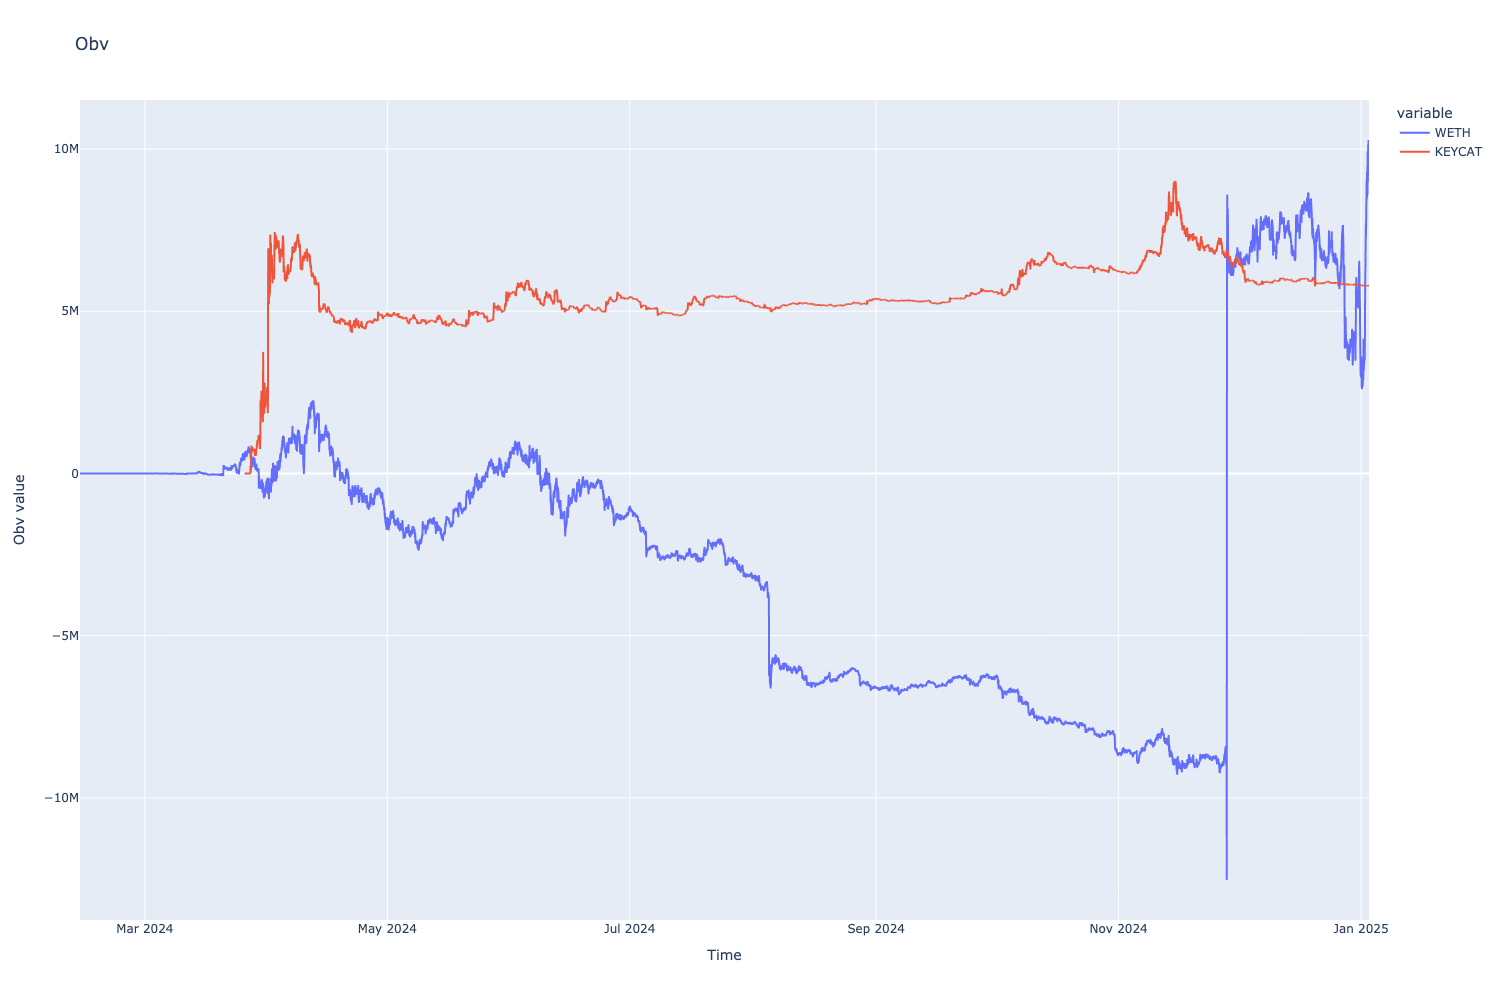

In [249]:

import plotly.express as px

selected_assets = ["WETH", "KEYCAT"]

checked_indicators = [
    # "volatility", 
    # "volatility_ewm", 
    # "trailing_sharpe_ewm", 
    "rsi",
    "roc",
    "obv"
]

for indicator_name in checked_indicators:

    data = {}
    for symbol in selected_assets:
        pair = token_map[symbol]
        data[symbol] = series = indicator_data.get_indicator_series(indicator_name, pair=pair)

        if series is None or len(series) == 0:
            print(f"Asset {symbol} has no data for {indicator_name}")

    df = pd.DataFrame(data)
    fig = px.line(df, title=f"{indicator_name.capitalize()}")
    fig.update_layout(showlegend=True)
    fig.update_yaxes(title=f"{indicator_name.capitalize()} value")
    fig.update_xaxes(title="Time")
    fig.show()

# TVL data

- Examine TVL data of some pairs

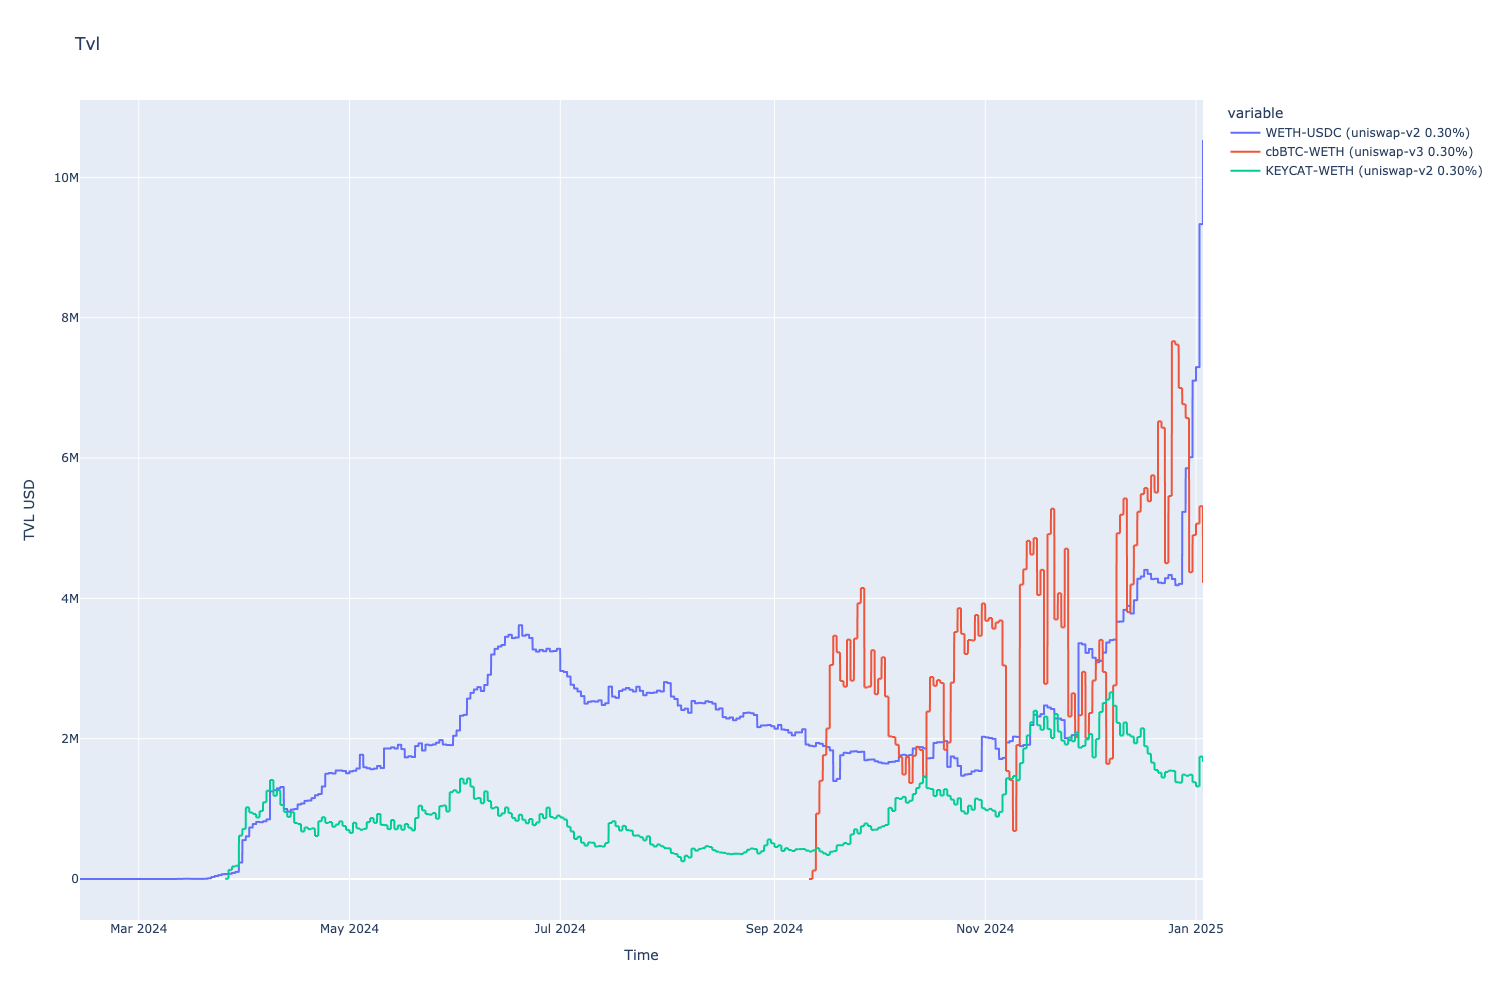

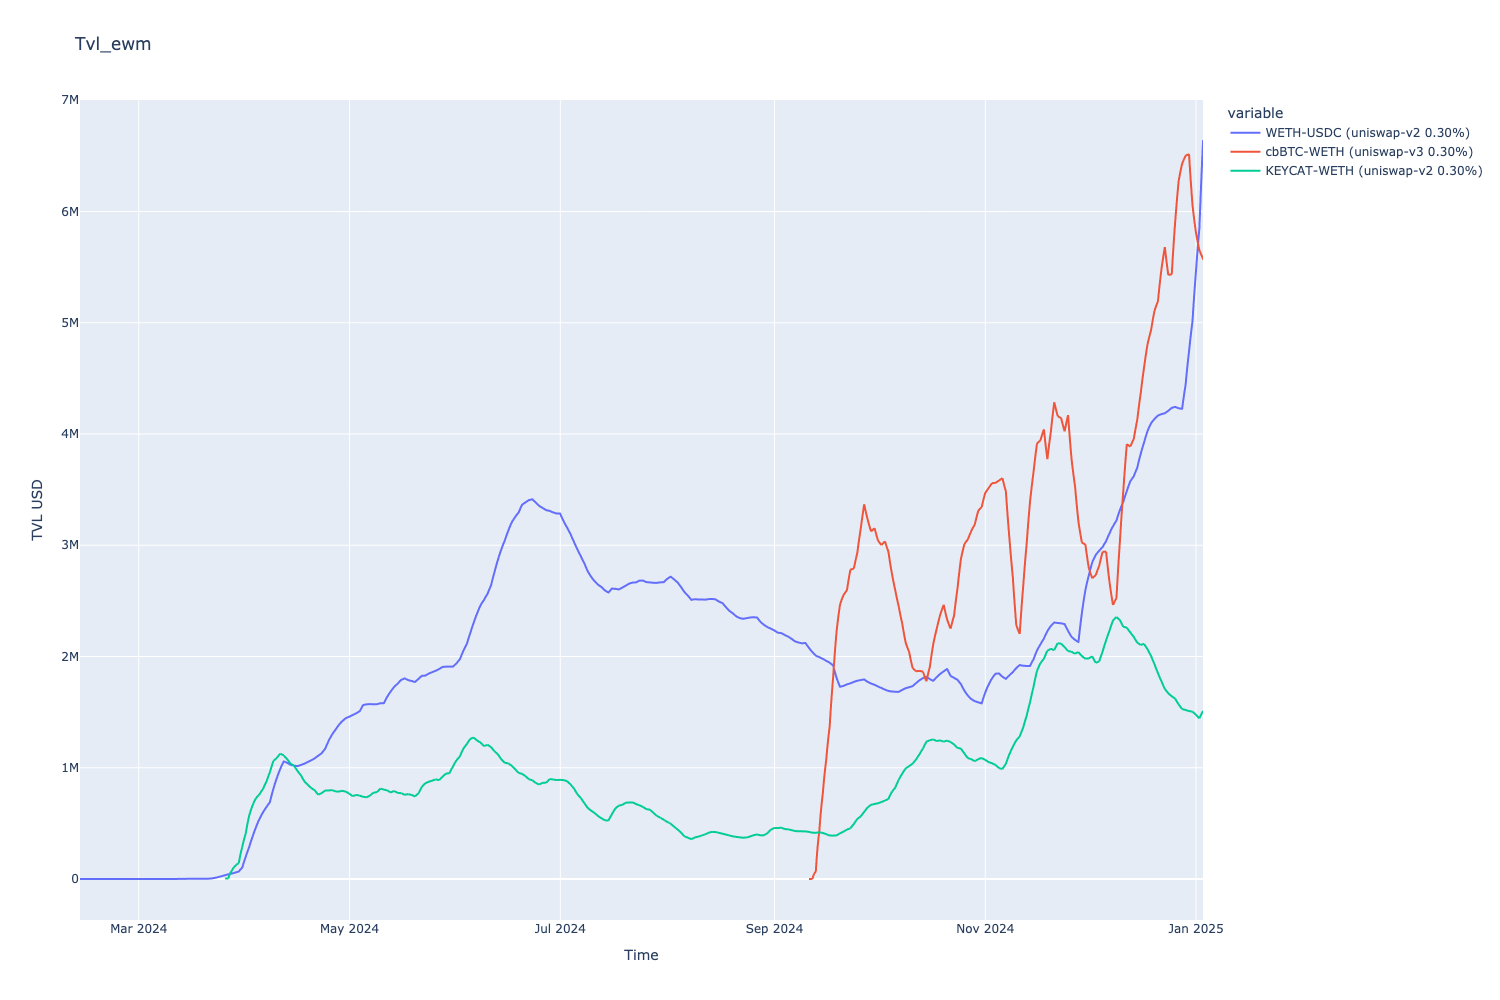

In [250]:
import plotly.express as px

selected_assets = ["WETH", "cbBTC", "KEYCAT"]
checked_indicators = ["tvl", "tvl_ewm"]

for indicator_name in checked_indicators:

    data = {}
    for symbol in selected_assets:
        pair = token_map[symbol]
        label = f"{pair.get_ticker()} ({pair.exchange_name} {pair.fee:.2%})"
        data[label] = series = indicator_data.get_indicator_series(indicator_name, pair=pair)

        if series is None or len(series) == 0:
            print(f"Asset {symbol} has no data for {indicator_name}")

    df = pd.DataFrame(data)
    fig = px.line(df, title=f"{indicator_name.capitalize()}")
    fig.update_layout(showlegend=True)
    fig.update_yaxes(title=f"TVL USD")
    fig.update_xaxes(title="Time")
    fig.show()